# 0. Import libraries

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [2]:
import celloracle as co
co.check_python_requirements()
co.__version__

'0.10.5'

In [3]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.2. Make a folder to save graph

In [4]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)


In [5]:
adata = sc.read_h5ad("./fibroblast_RNA.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 38677 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'cell.type', 'condition', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'Fibro_z', 'Pericyte_z', 'SMC_z', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'active_ident'
    var: 'variable_gene'
    uns: 'RNA_snn_res.0.4_colors', 'active_ident_colors', 'seurat_clusters_colors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    layers: 'raw_count'

In [7]:
di = {"Donor": "Donor", "NRpre": "preLVAD HF", "Rpre":"preLVAD HF", "NRpost":"NRpost",
      "Rpost":"Rpost"}
adata.obs = adata.obs.replace({"condition": di})

In [8]:
adata.obs["condition"].value_counts()

Donor         15499
preLVAD HF    11109
NRpost         6970
Rpost          5099
Name: condition, dtype: int64

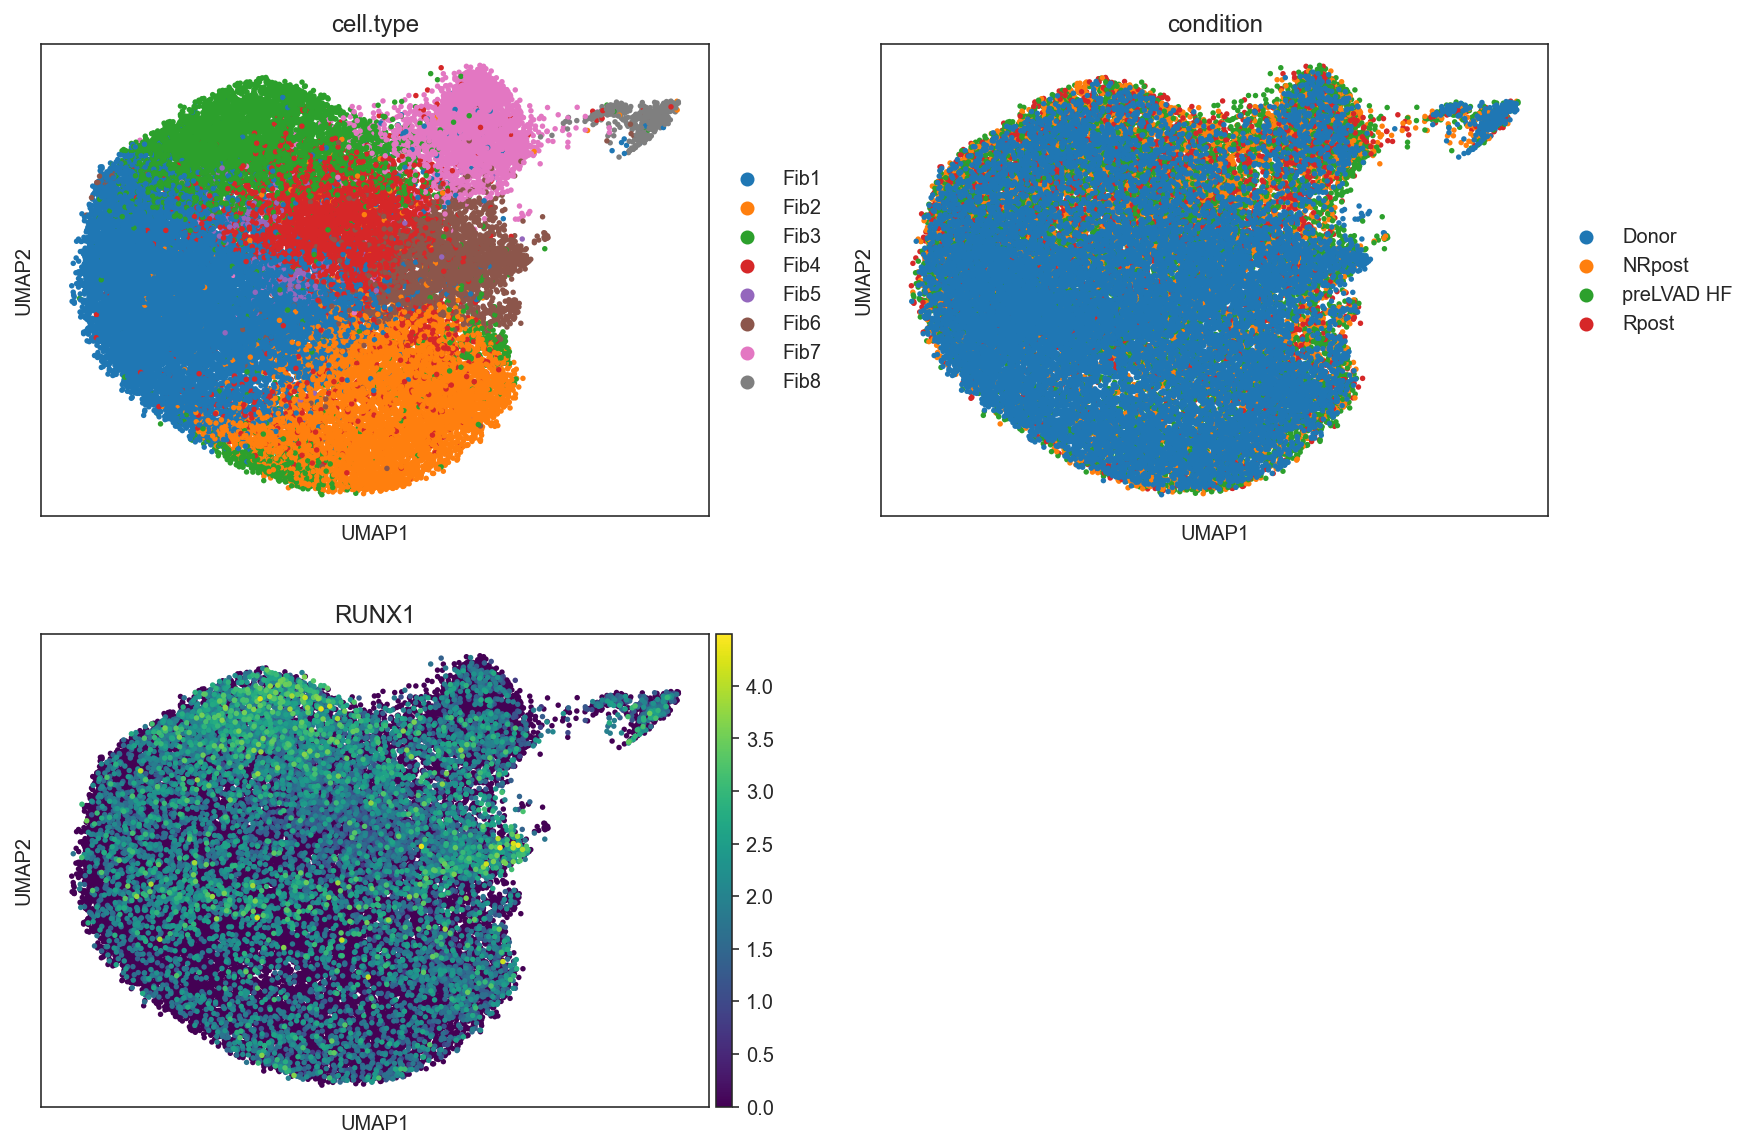

In [9]:
sc.pl.umap(adata, color=["cell.type",'condition', 'RUNX1'], s=30, cmap="viridis", ncols=2)

In [10]:
adata.obs["condition_and_celltype"] = adata.obs["condition"].astype("str") + "_" + adata.obs['cell.type'].astype("str") 

In [11]:
sc.tl.embedding_density(adata, basis='umap', groupby='condition')

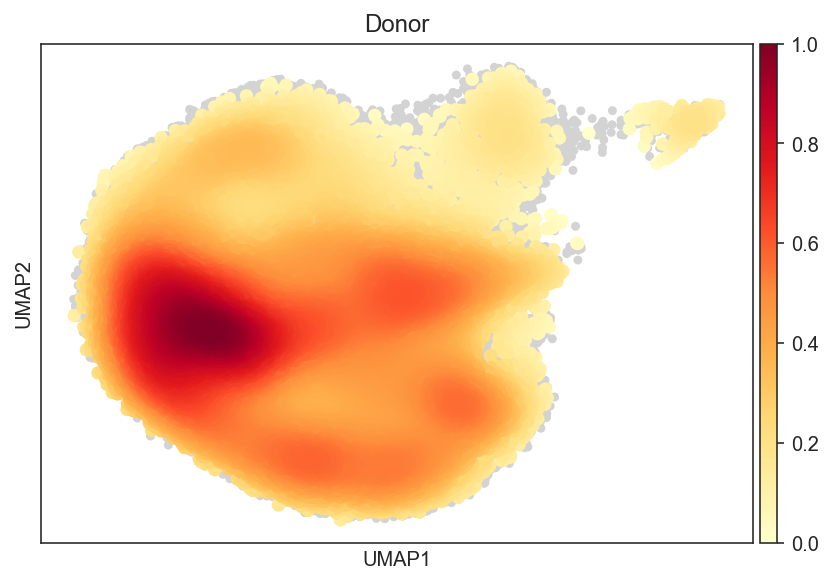

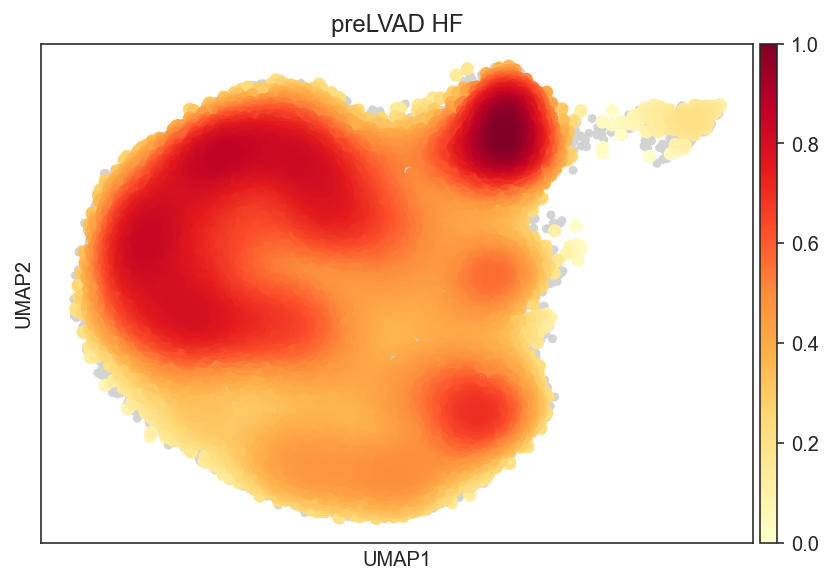

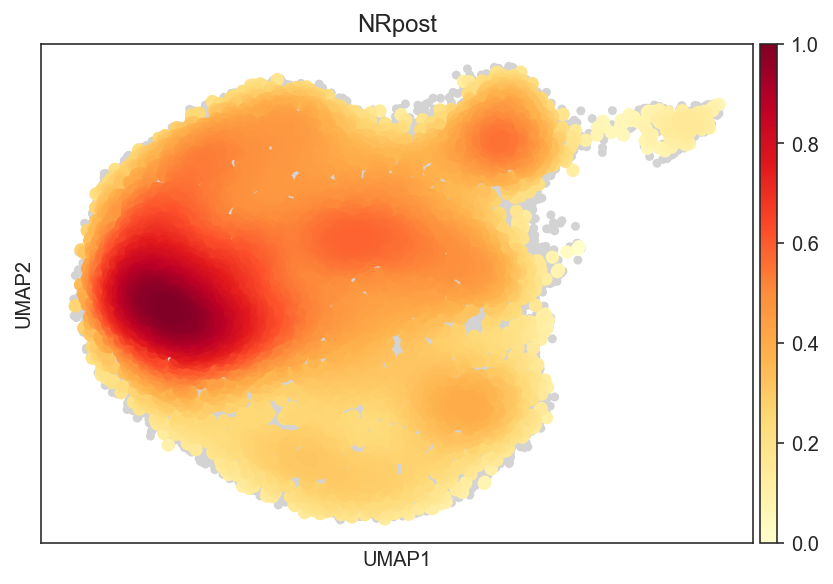

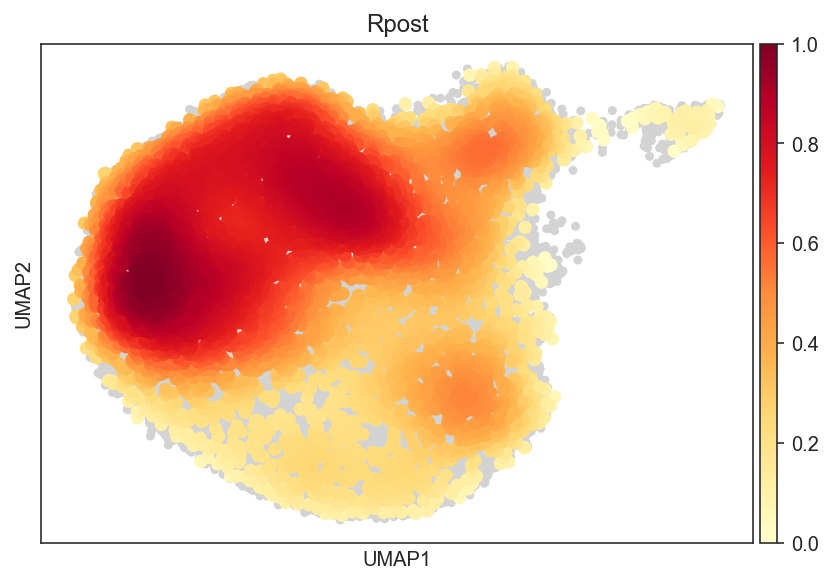

In [12]:
for i in adata.obs.condition.unique():
    sc.pl.embedding_density(
        adata, basis='umap', key='umap_density_condition', group=i
    )

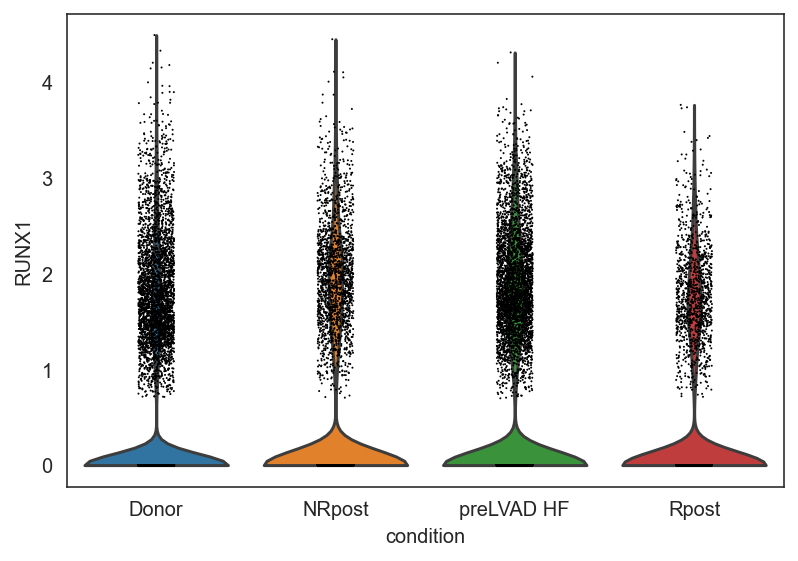

In [13]:
sc.pl.violin(adata, keys=[ "RUNX1"], groupby="condition")

## 1.2. (Optional step) Downsampling

If your scRNA-seq data includes more than 20-30K cells, we recommend downsampling your data. If you do not, please note the perturbation simulations may require large amounts of memory in the next notebook. 

Also, please pay attention to the number of genes. If you are following the instruction from the previous tutorial notebook, the scRNA-seq data should include only top 2~3K variable genes. If you have more than 3K genes, it may cause issues downstream.

In [14]:
print(f"Cell number is :{adata.shape[0]}")
print(f"Gene number is :{adata.shape[1]}")

Cell number is :38677
Gene number is :33694


In [15]:
# Random downsampling into 20K cells if the anndata object include more than 20 K cells.
n_cells_downsample = 20000 
if adata.shape[0] > n_cells_downsample:
    # Let's dowmsample into 30K cells
    sc.pp.subsample(adata, n_obs=n_cells_downsample, random_state=123)

In [16]:
print(f"Cell number is :{adata.shape[0]}")

Cell number is :20000


In [17]:
var_gene = adata.var.index[adata.var.variable_gene].values
adata = adata[:, var_gene]


In [18]:
adata.X

<20000x3000 sparse matrix of type '<class 'numpy.float32'>'
	with 5050574 stored elements in Compressed Sparse Row format>

## 1.2. Load base-GRN data. 
To infer cluster-specific GRNs, CellOracle requires a base GRN. 
- There are several ways to make a base GRN. We can typically generate base GRN from scATAC-seq data or bulk ATAC-seq data. Please refer to the first step of the tutorial to learn more about this process. https://morris-lab.github.io/CellOracle.documentation/tutorials/base_grn.html


- If you do not have your scATAC-seq data, you can use one of the built-in base GRNs options below. 

- Base GRNs made from mouse sci-ATAC-seq atlas : The built-in base GRN was made from various tissue/cell-types found in the atlas (http://atlas.gs.washington.edu/mouse-atac/). We recommend using this for mouse scRNA-seq data. Please load this data as follows.

 `base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()`


- Promoter base GRN: We also provide base GRN made from promoter DNA-sequences for ten species. You can load this data as follows.

 - e.g. for Human: `base_GRN = co.data.load_human_promoter_base_GRN()`



In [19]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_human_promoter_base_GRN()

# Check data
base_GRN.head()

Loading prebuilt promoter base-GRN. Version: hg19_gimmemotifsv5_fpr2


peak_id gene_short_name  9430076C15RIK  AC002126.6  \
0  chr10_100027907_100029007           LOXL4            0.0         0.0   
1  chr10_100154964_100156064         MIR1287            0.0         0.0   
2  chr10_100174878_100175978         PYROXD2            0.0         0.0   
3  chr10_100191017_100192117         MIR4685            0.0         1.0   
4  chr10_100205078_100206178    LOC101927278            0.0         0.0   

   AC012531.1  AC226150.2  AFP  AHR  AHRR  AIRE  ...  ZNF784  ZNF8  ZNF816  \
0         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
1         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
2         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
3         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   
4         0.0         0.0  0.0  0.0   0.0   0.0  ...     0.0   0.0     0.0   

   ZNF85  ZSCAN10  ZSCAN16  ZSCAN22  ZSCAN26  ZSCAN31  ZSCAN4  
0    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
1    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
2    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
3    0.0      0.0      0.0      0.0      0.0      0.0     0.0  
4    0.0      0.0      0.0      0.0      0.0      0.0     0.0  

[5 rows x 1096 columns]

# 2. Make Oracle object

We will use an Oracle object during the data preprocessing and GRN inference steps. Using its internal functions, the Oracle object computes and stores all of the necessary information for these calculations. To begin, we will instantiate a new Oracle object and input our gene expression data (anndata) and TF info (base GRN).

In [20]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

For the CellOracle analysis, your anndata should include (1) gene expression counts, (2) clustering information, and (3) trajectory (dimensional reduction embedding) data. Please refer to a previous notebook for more information on anndata preprocessing.


When you load the scRNA-seq data, please enter **the name of the clustering data** and **the name of the dimensionality reduction.**
 - The clustering data should be to be stored in the `obs` the attribute of anndata. 
  > You can check it using the following command.
  >
  > `adata.obs.columns`
  
 - Dimensional reduction data is stored in the `obsm` the attribute of anndata. 
  > You can check it with the following command.
  > 
  > `adata.obsm.keys()`
  


In [21]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.3', 'seurat_clusters', 'cell.type', 'condition', 'RNA_snn_res.0.2', 'RNA_snn_res.0.3', 'RNA_snn_res.0.4', 'RNA_snn_res.0.5', 'RNA_snn_res.0.6', 'Fibro_z', 'Pericyte_z', 'SMC_z', 'SCT_snn_res.0.1', 'SCT_snn_res.0.2', 'SCT_snn_res.0.4', 'SCT_snn_res.0.5', 'active_ident', 'condition_and_celltype', 'umap_density_condition']
Dimensional reduction:  ['X_harmony', 'X_pca', 'X_umap']


In [22]:
# In this notebook, we use the unscaled mRNA count for the nput of Oracle object.
adata.X = adata.layers["raw_count"].copy()
sc.pp.normalize_per_cell(adata)

In [23]:
# Instantiate Oracle object.
cluster_column_name = 'cell.type'
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name=cluster_column_name,
                                   embedding_name="X_umap")

## 2.2. Load base-GRN data into oracle object

In [24]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# Alternatively, if you saved the informmation as a dictionary, you can use the code below.
# oracle.import_TF_data(TFdict=TFinfo_dictionary)

In [25]:
oracle.adata.var.loc["RUNX1"]

variable_gene                   True
symbol                         RUNX1
isin_top1000_var_mean_genes     True
isin_TFdict_targets             True
isin_TFdict_regulators          True
Name: RUNX1, dtype: object

# 3. KNN imputation
CellOracle uses the same strategy as velocyto for visualizing cell transitions. This process requires KNN imputation in advance.

For the KNN imputation, we first need to calculate and select PCs.

## 3.1. PCA

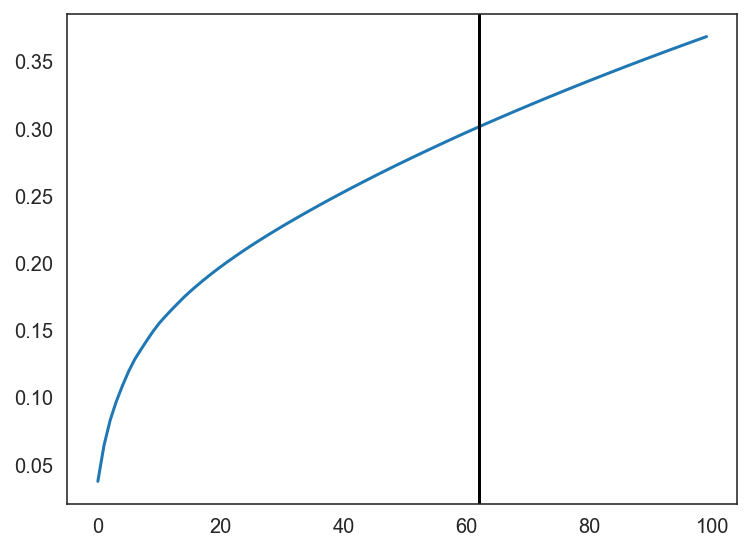

62


In [26]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [27]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :20000


In [28]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :500


In [29]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

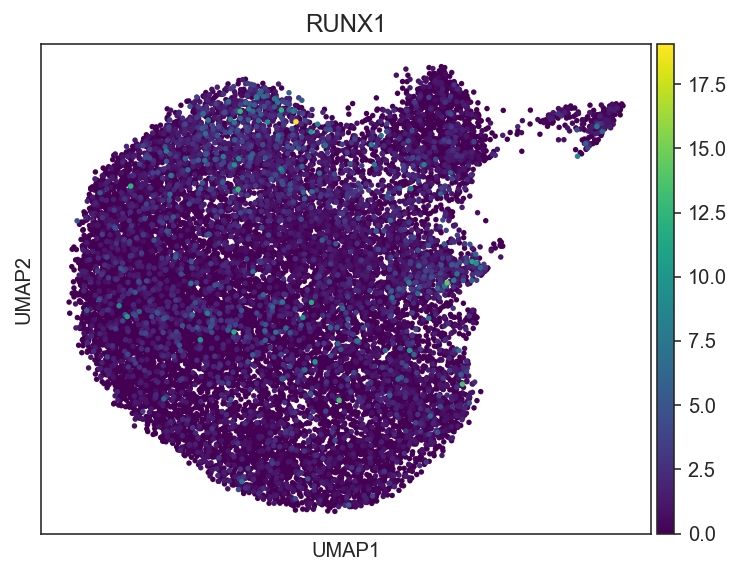

In [30]:
sc.pl.umap(oracle.adata, layer="raw_count",
           color=["RUNX1"], s=30, cmap="viridis")

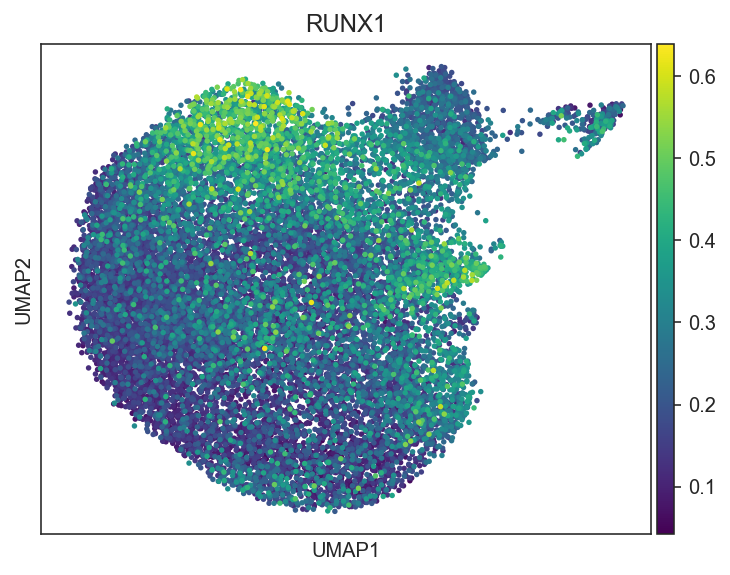

In [31]:
sc.pl.umap(oracle.adata, layer="imputed_count",
           color=["RUNX1"], s=30, cmap="viridis")

# 4. Save and Load.

You can save your `Oracle` object using `Oracle.to_hdf5(FILE_NAME.celloracle.oracle)`. 

Pleasae use `co.load_hdf5(FILE_NAME.celloracle.oracle)` to load the saved file.


In [32]:
# Save oracle object.
oracle.to_hdf5("Fibroblast.celloracle.oracle")

# 5. GRN calculation
The next step constructs a cluster-specific GRN for all clusters.

- You can calculate GRNs with the `get_links` function, and it will return the results as a `Links` object.
The `Links` object stores the inferred GRNs and the corresponding metadata. Most network structure analysis is performed with the `Links` object.

- A GRN will be calculated for each cluster/sub-group. In the example below, we construct GRN for each unit of the "louvain_annot" clustering.



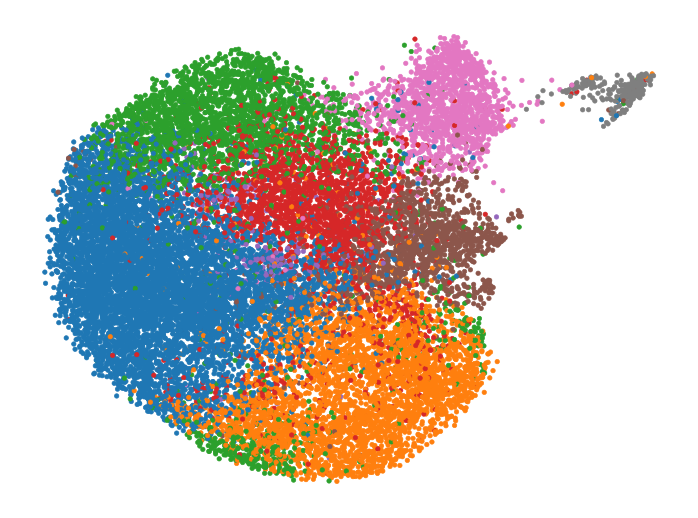

In [33]:
oracle.plot_cluster_whole()

## 5.1. Get GRNs

In [34]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)

unit = cluster_column_name
links = oracle.get_links(cluster_name_for_GRN_unit=unit, alpha=10, verbose_level=10)
# Calculate network scores. 
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()

# Save Links object.
links.to_hdf5(file_path=f"links_fibroblast_{unit}.celloracle.links")

  0%|          | 0/8 [00:00<?, ?it/s]

inferring GRN for Fib1...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib2...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib3...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib4...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib5...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib6...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib7...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Fib8...


  0%|          | 0/2247 [00:00<?, ?it/s]

CPU times: user 9min 59s, sys: 36 s, total: 10min 35s
Wall time: 13min 3s


In [35]:
%%time
# Calculate GRN for each population in "louvain_annot" clustering unit.
# This step may take some time.(~30 minutes)

unit = "condition"
links = oracle.get_links(cluster_name_for_GRN_unit=unit, alpha=10, verbose_level=10)
# Calculate network scores. 
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
links.get_network_score()
# Save Links object.
links.to_hdf5(file_path=f"links_fibroblast_{unit}.celloracle.links")

  0%|          | 0/4 [00:00<?, ?it/s]

inferring GRN for Donor...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for NRpost...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for Rpost...


  0%|          | 0/2247 [00:00<?, ?it/s]

inferring GRN for preLVAD HF...


  0%|          | 0/2247 [00:00<?, ?it/s]

CPU times: user 5min 37s, sys: 24.3 s, total: 6min 1s
Wall time: 8min 36s


## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

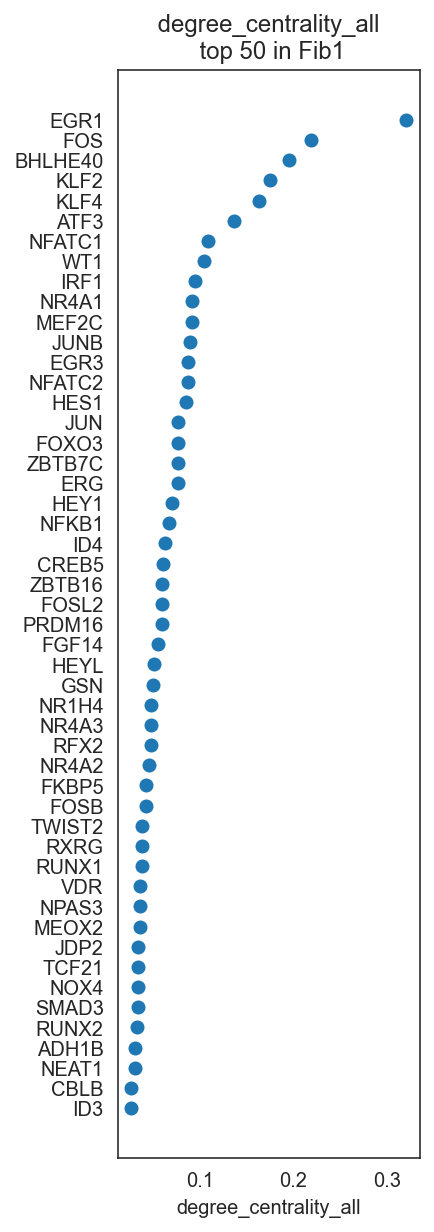

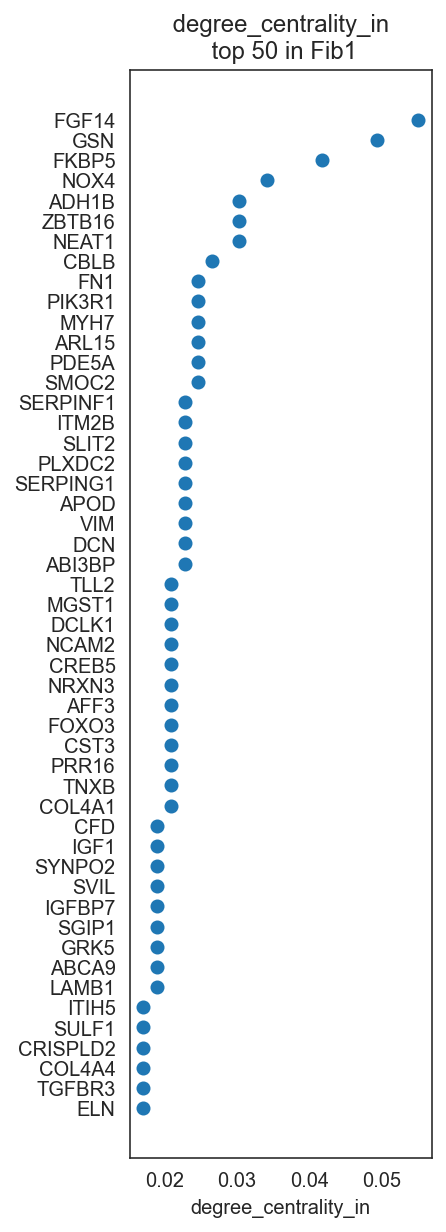

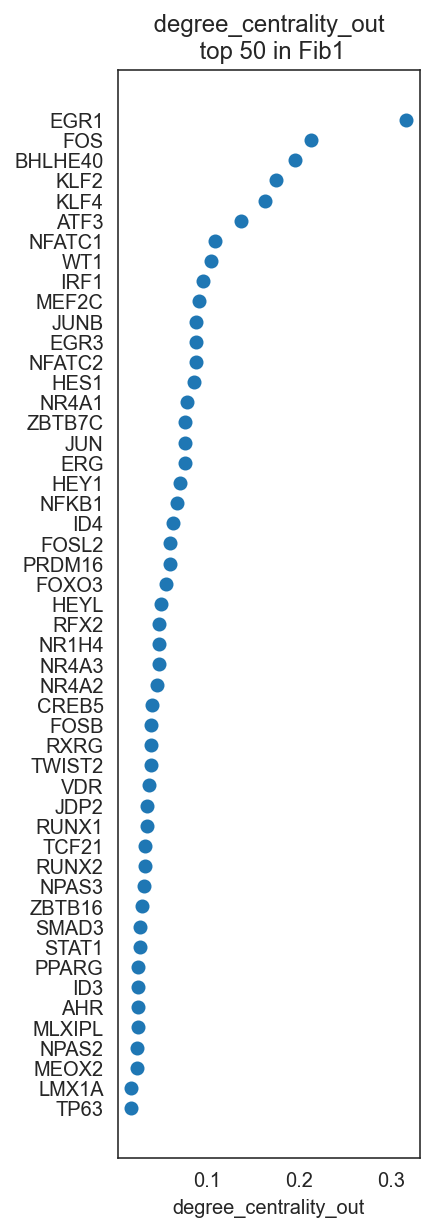

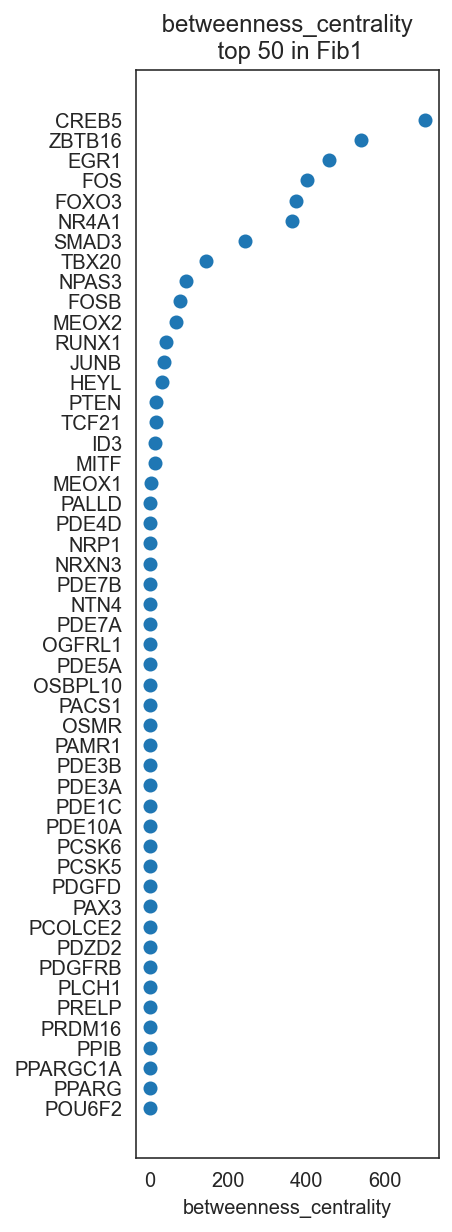

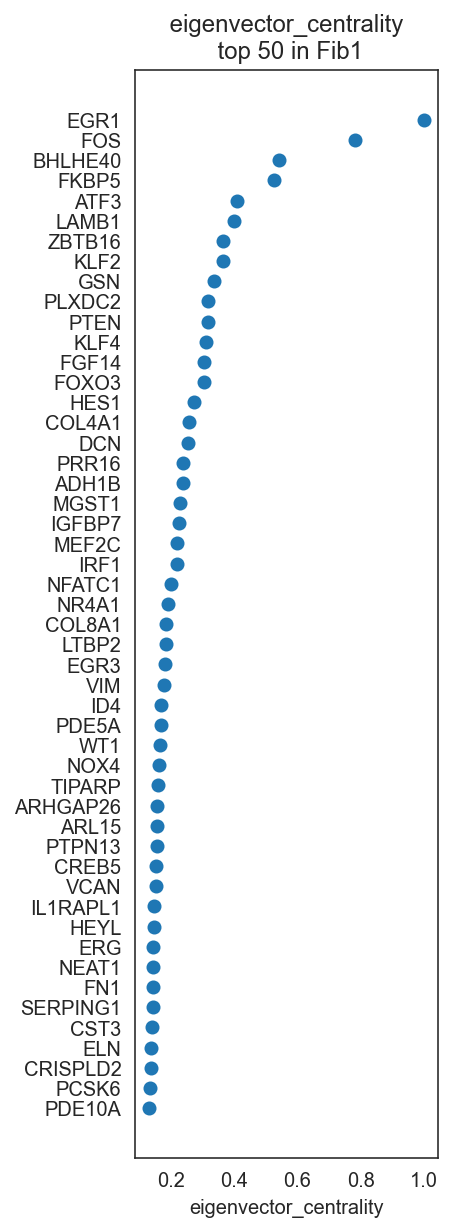

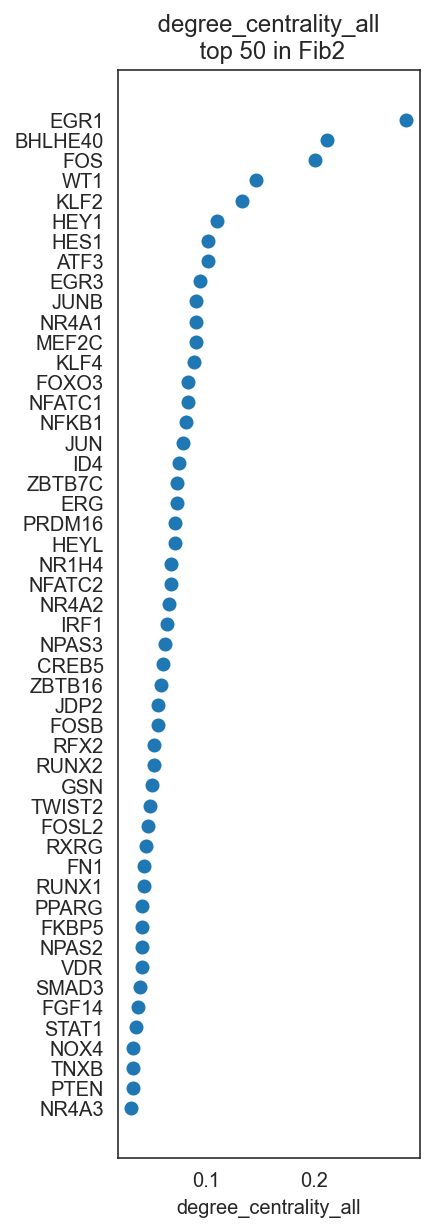

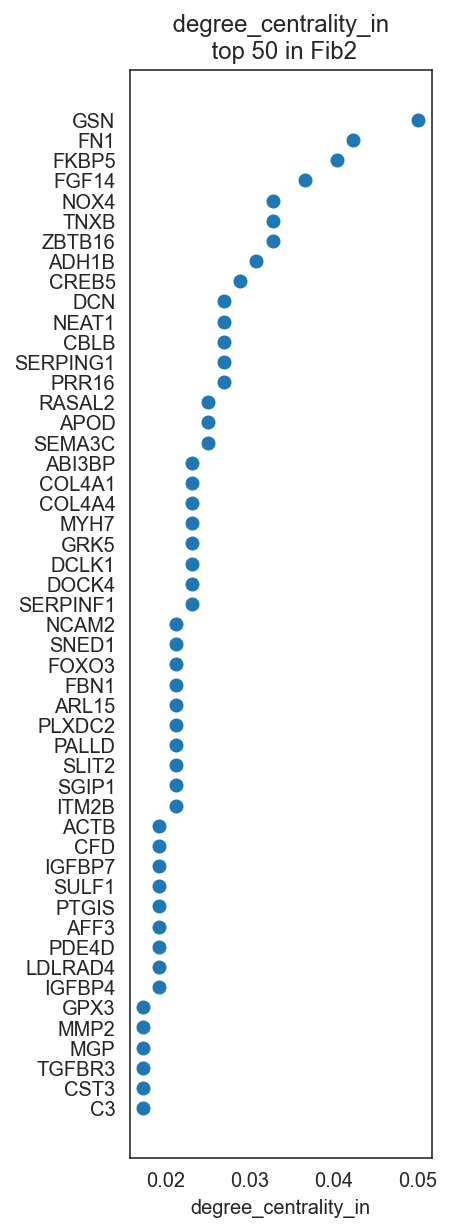

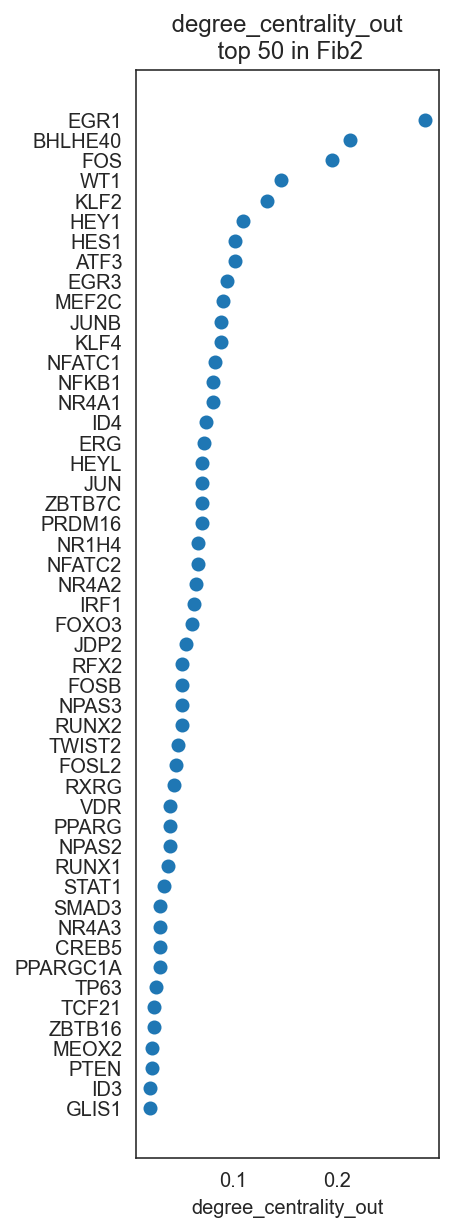

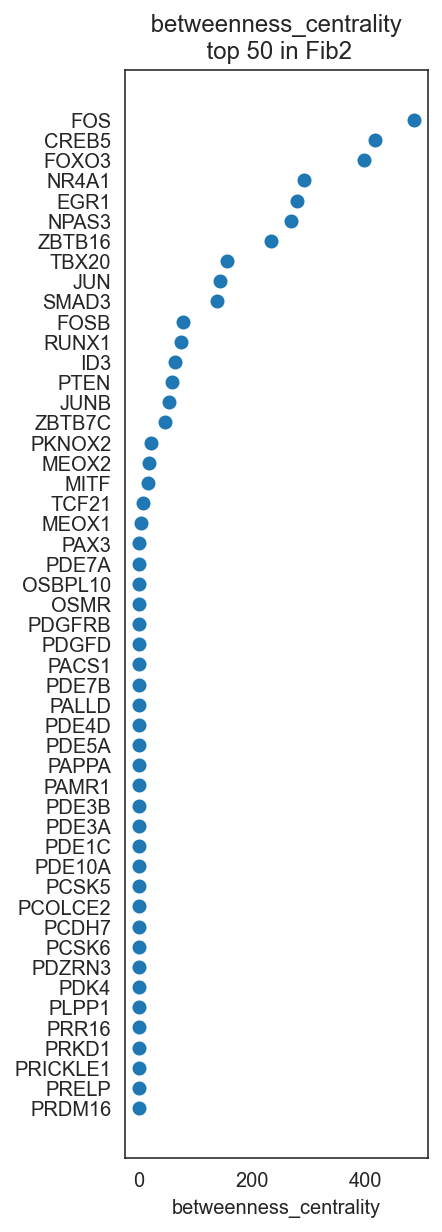

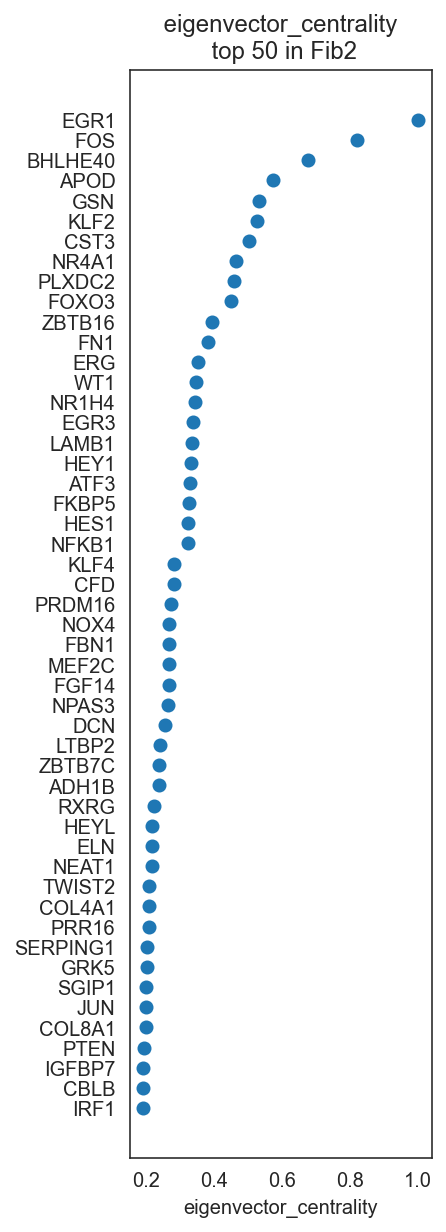

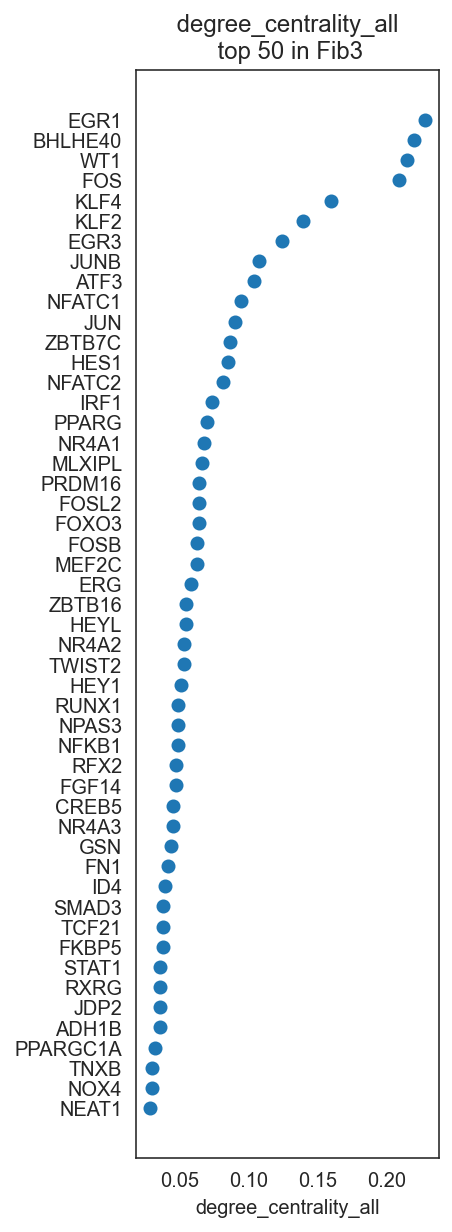

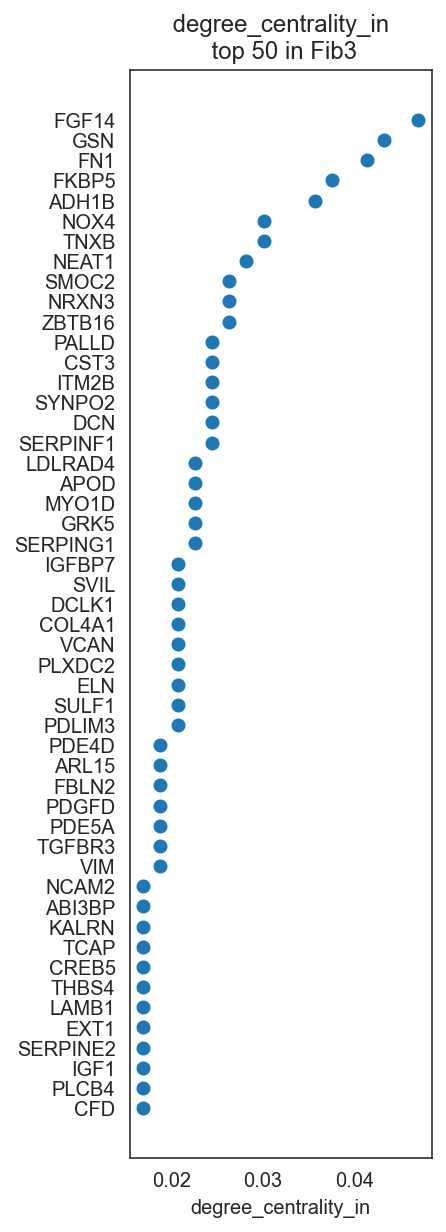

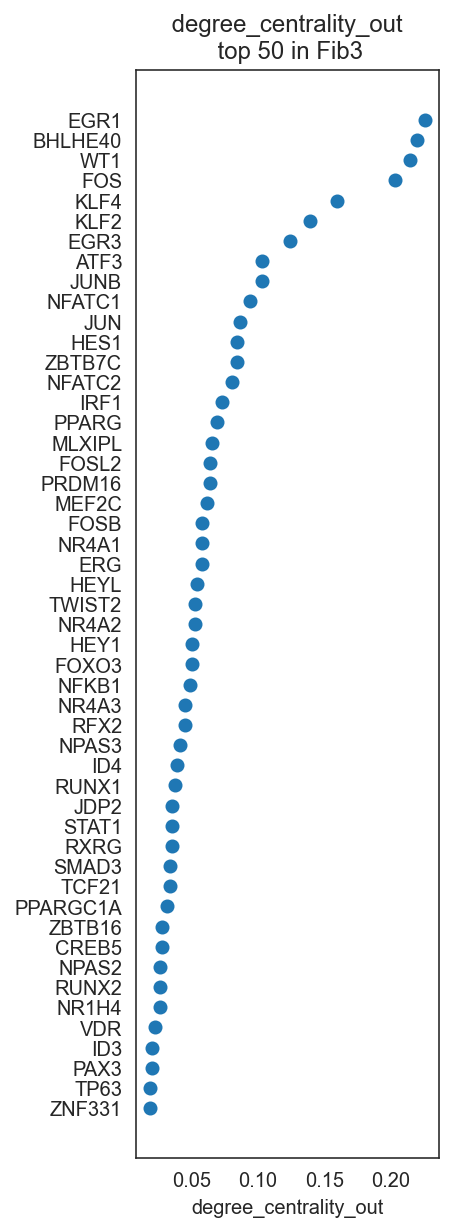

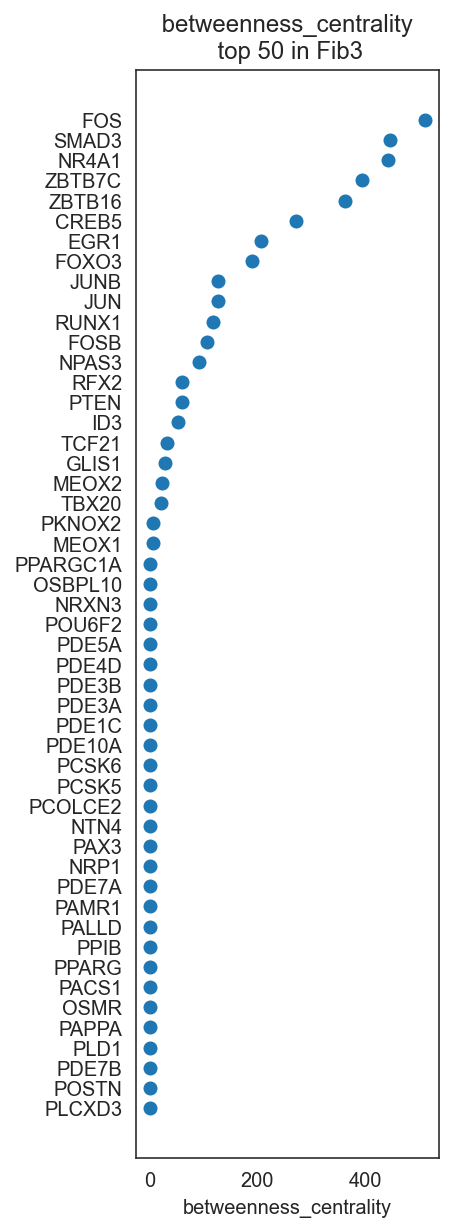

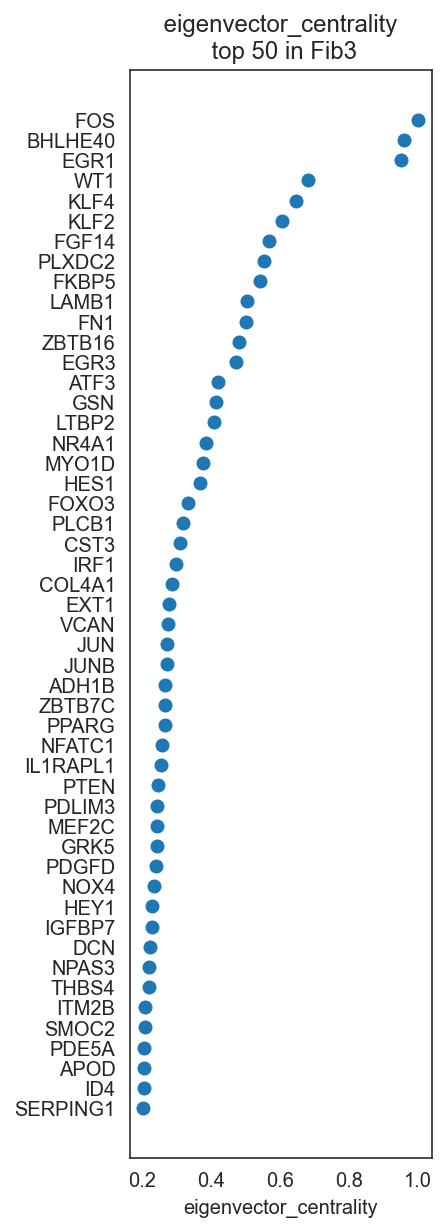

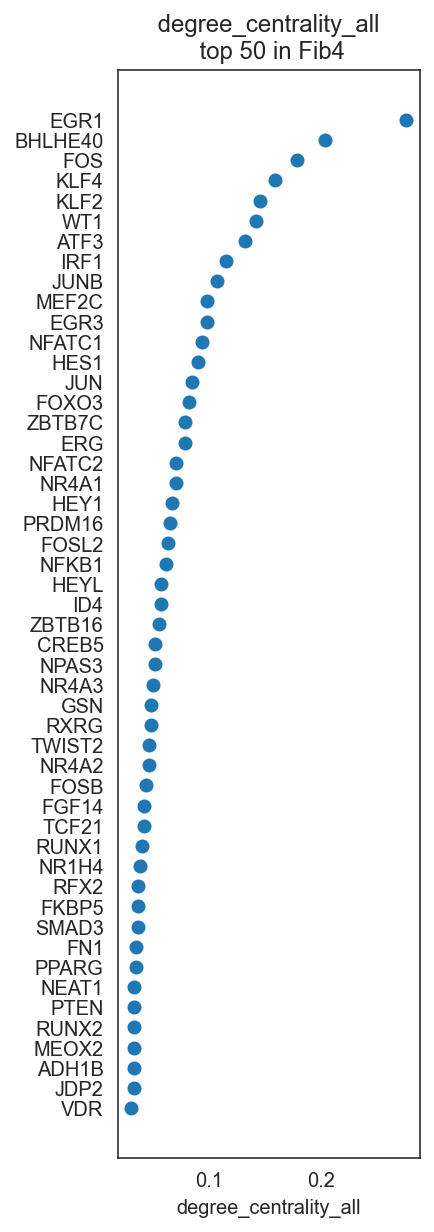

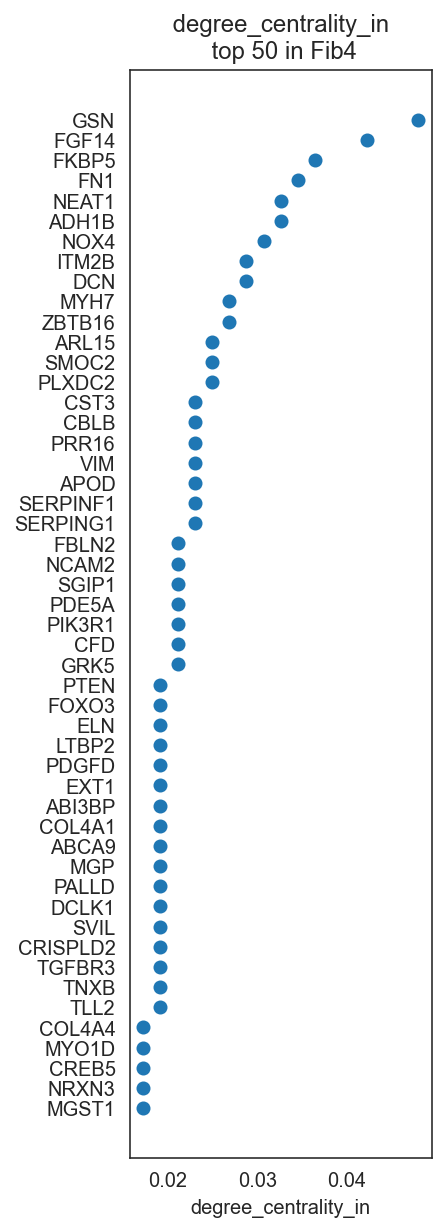

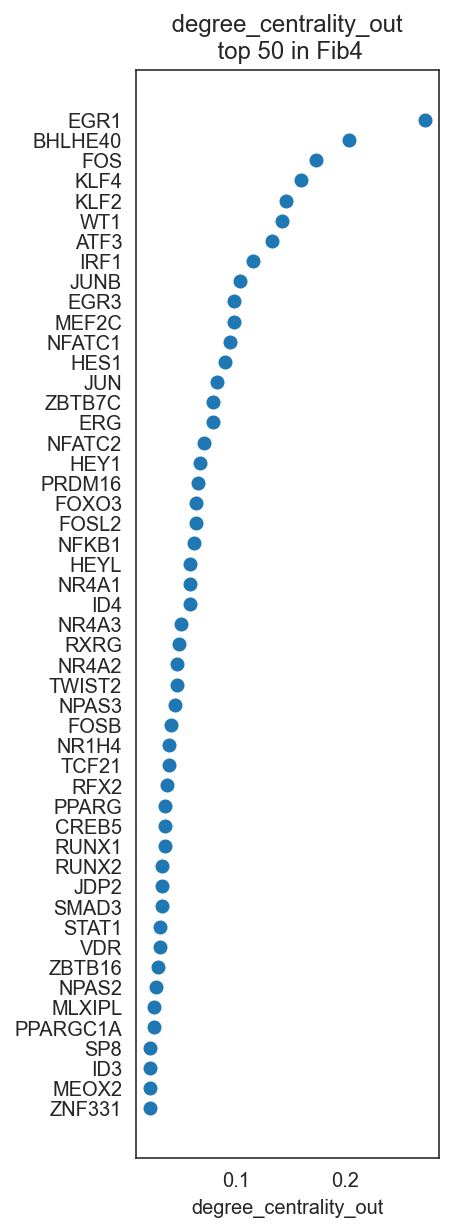

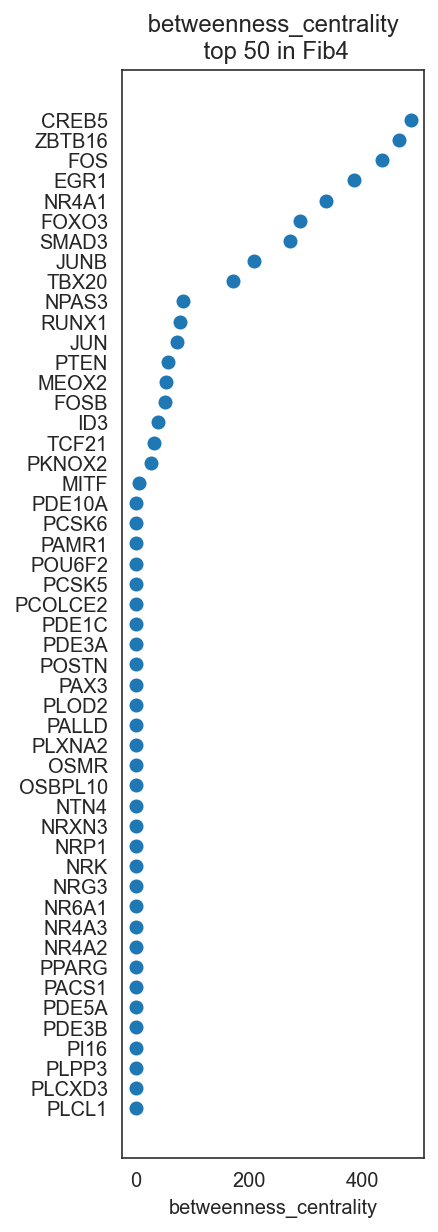

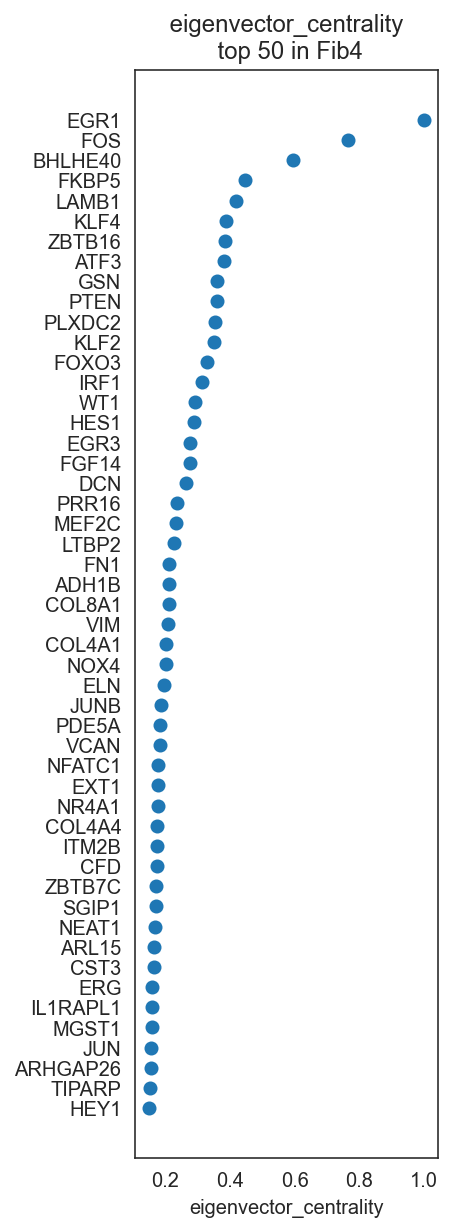

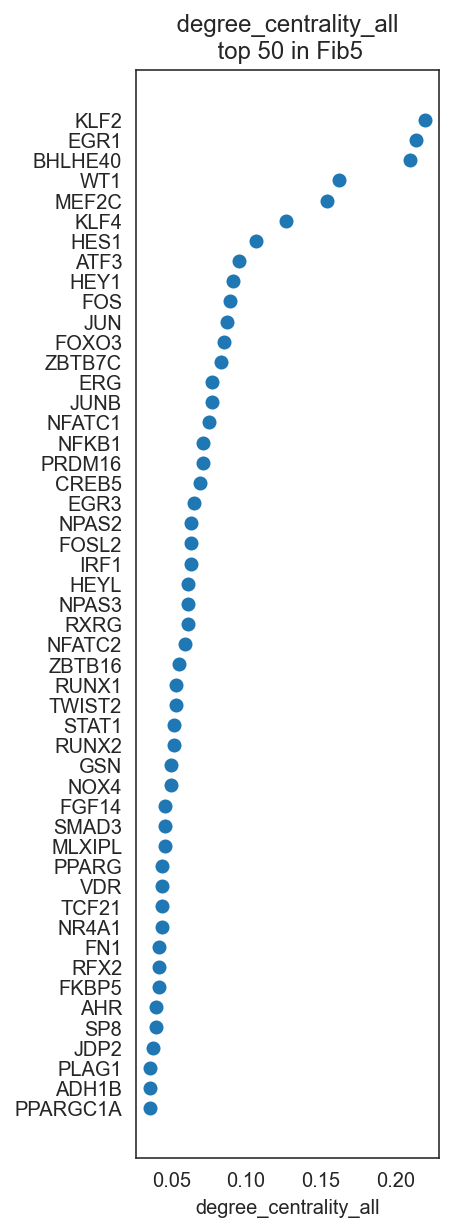

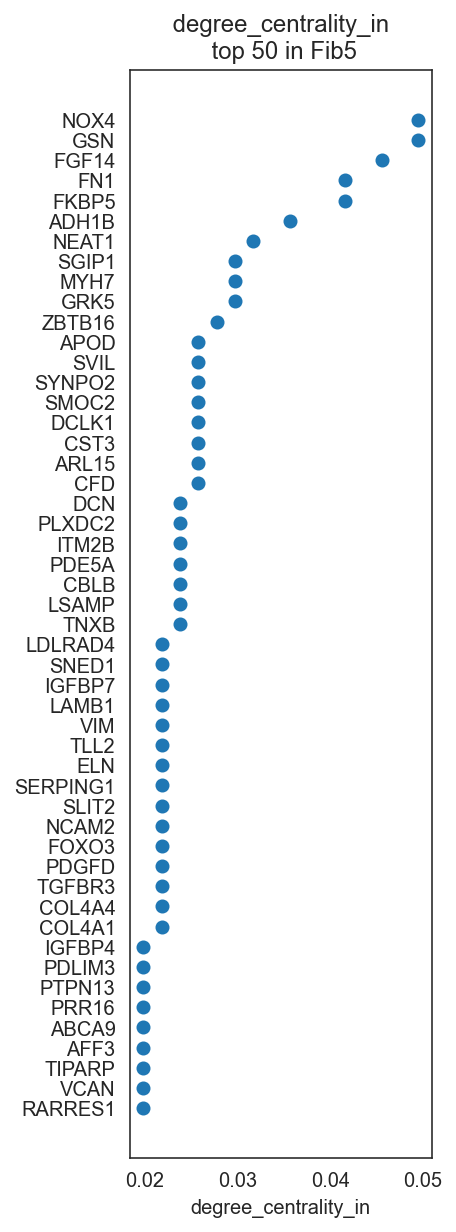

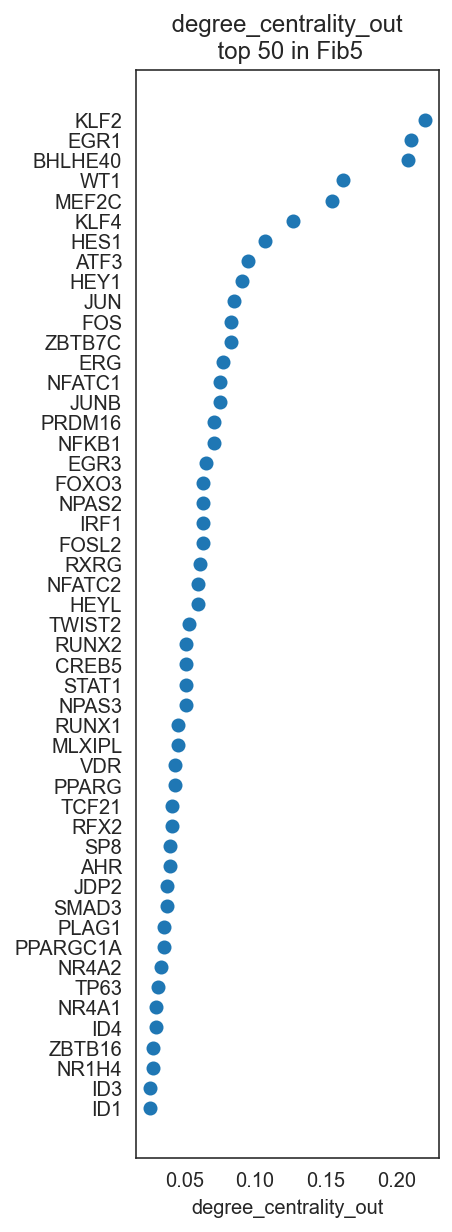

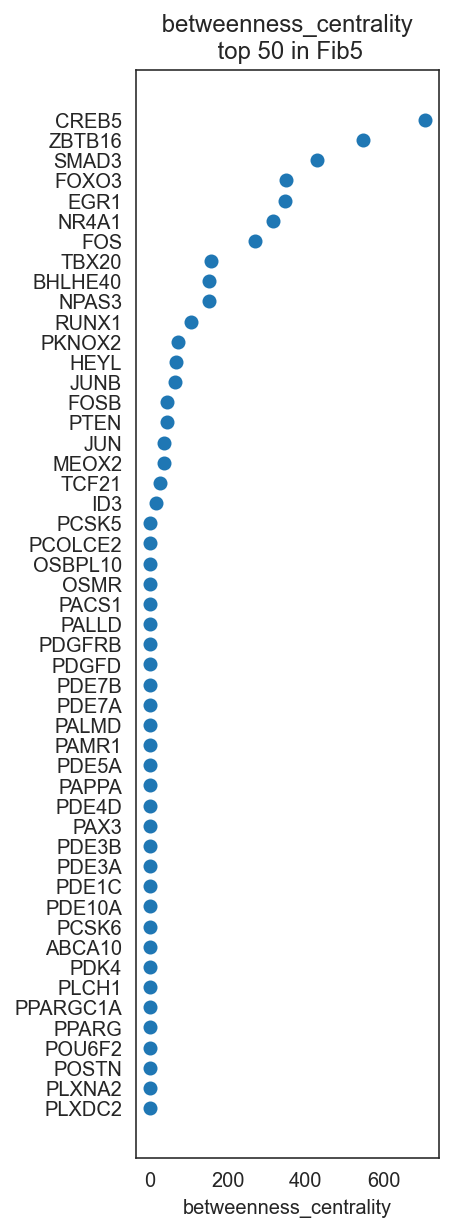

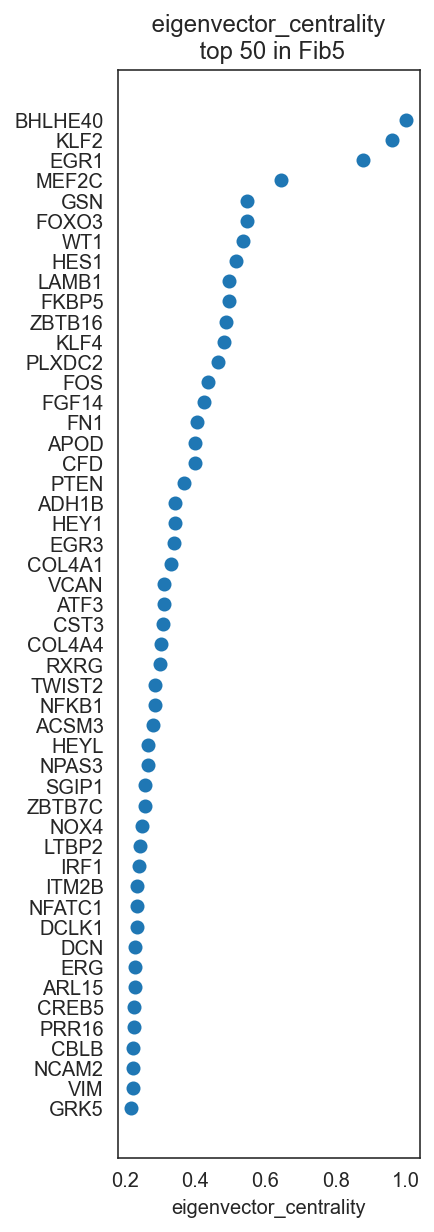

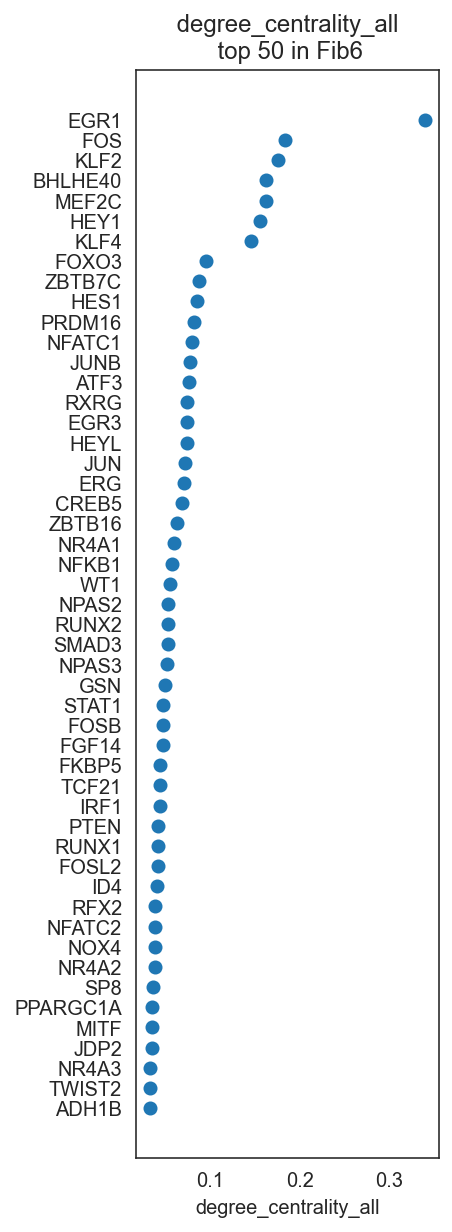

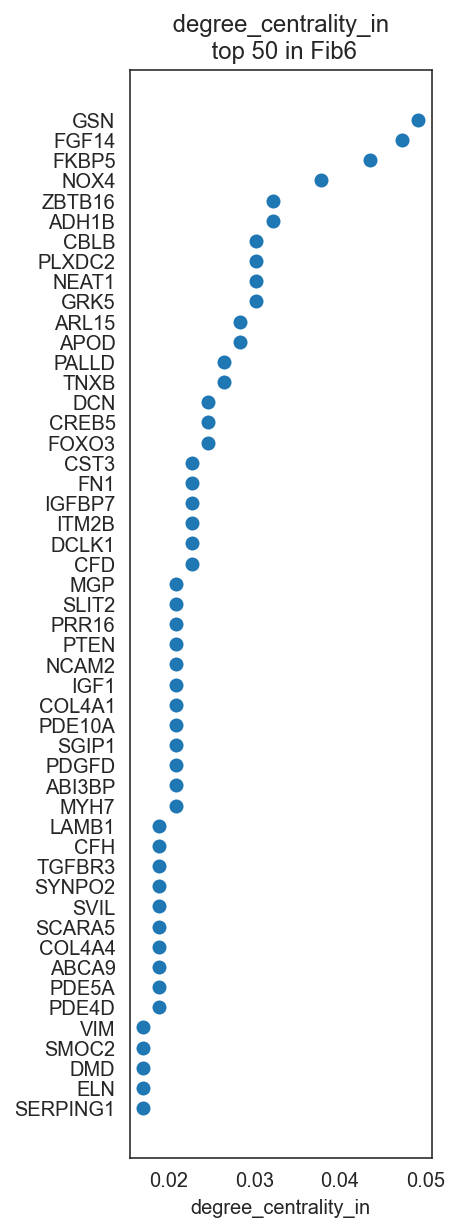

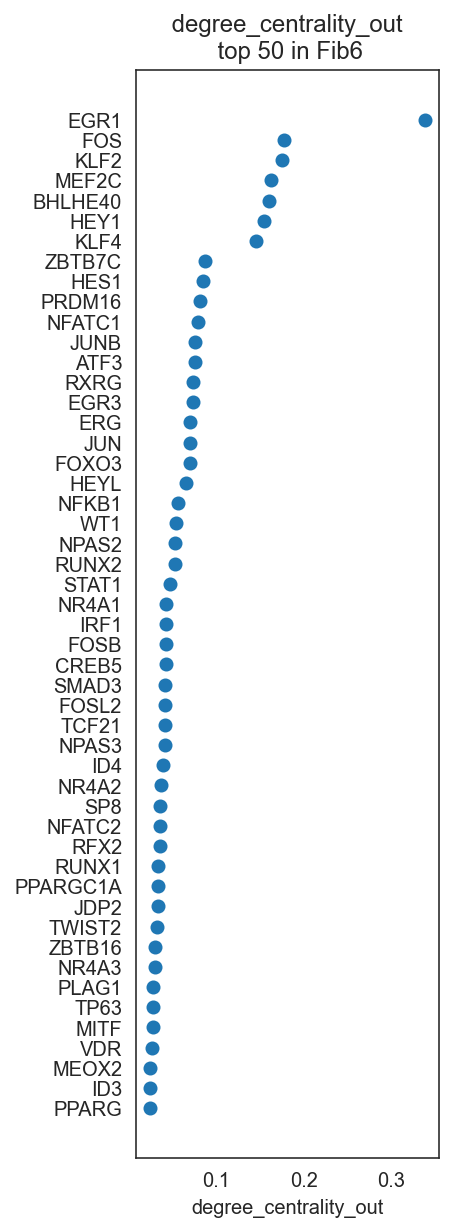

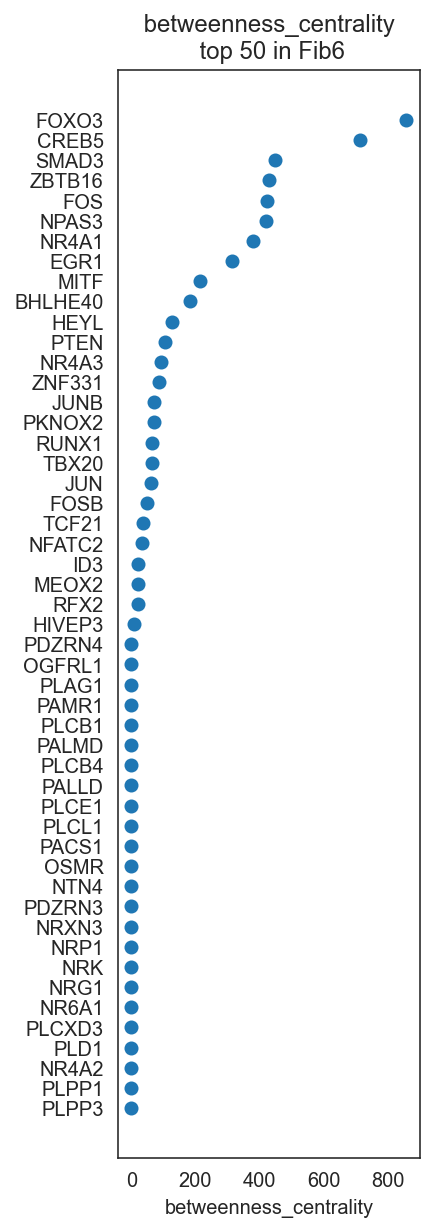

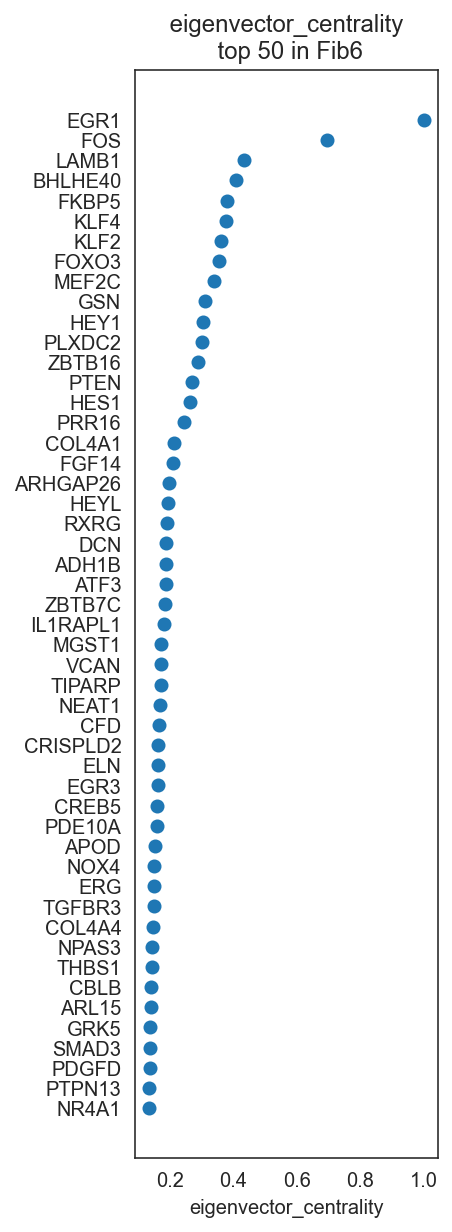

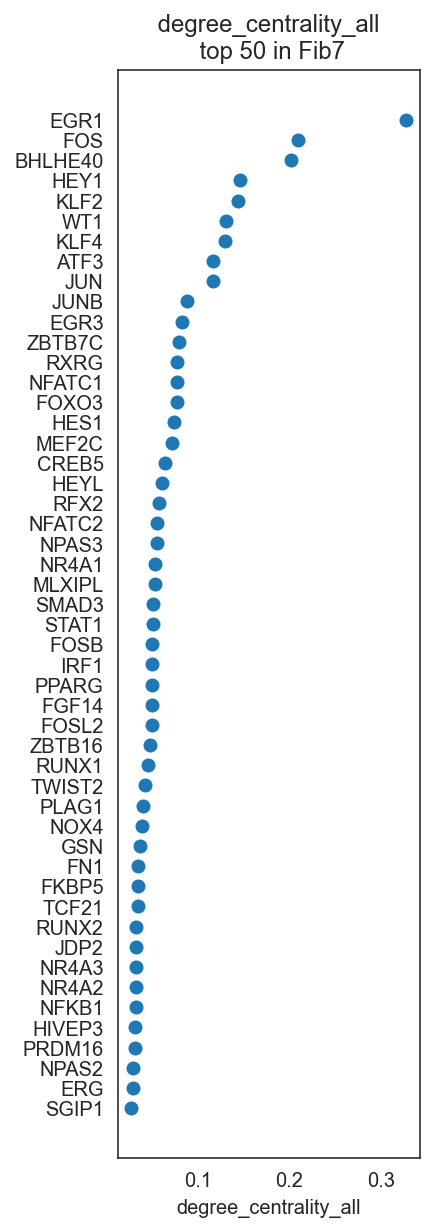

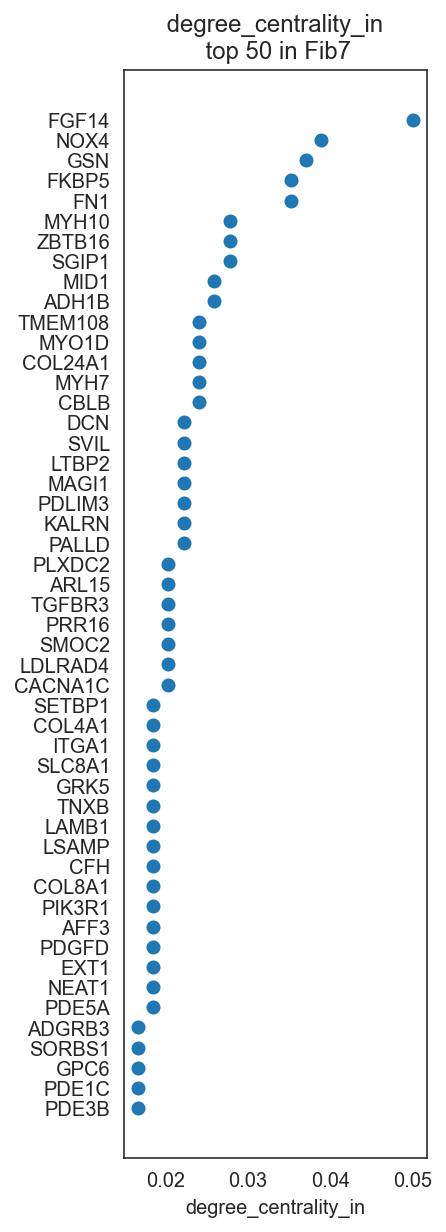

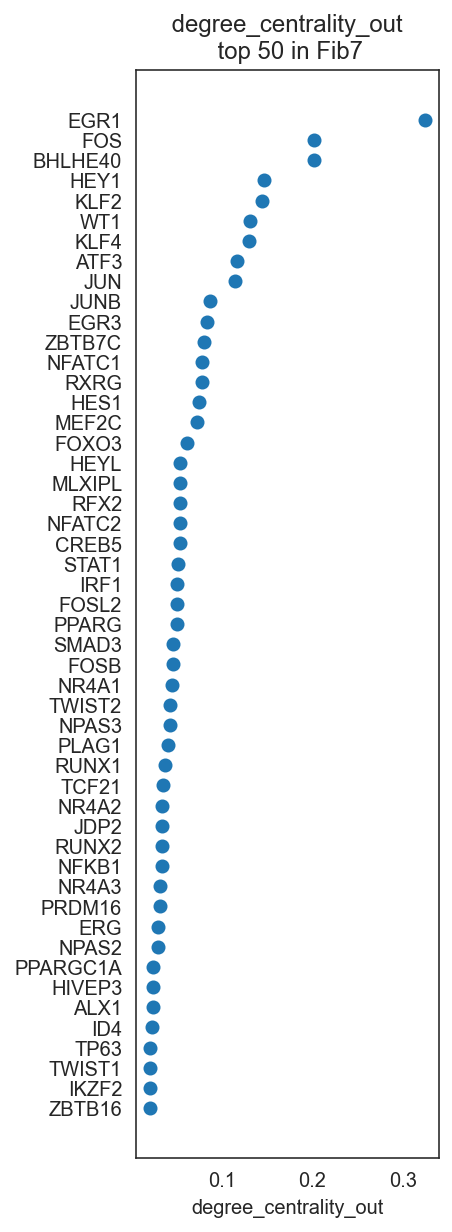

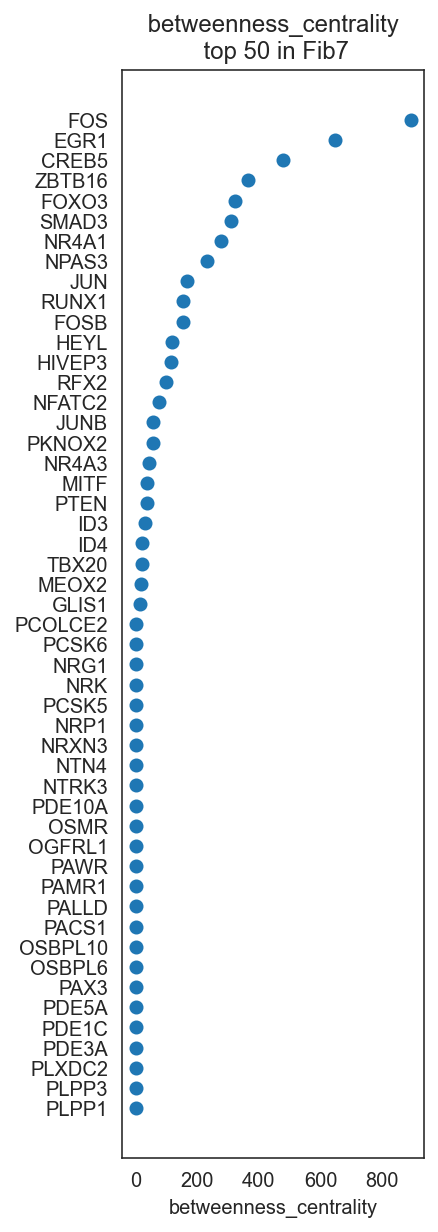

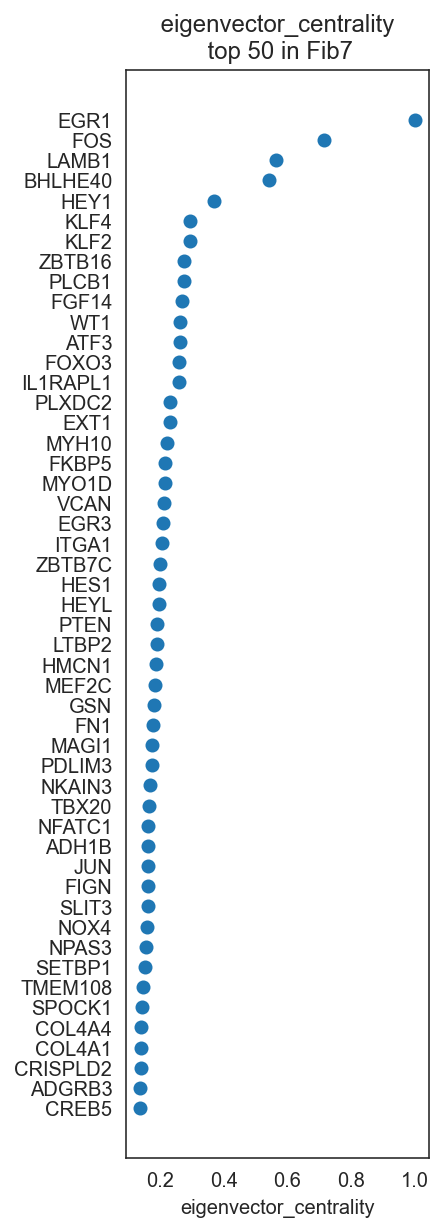

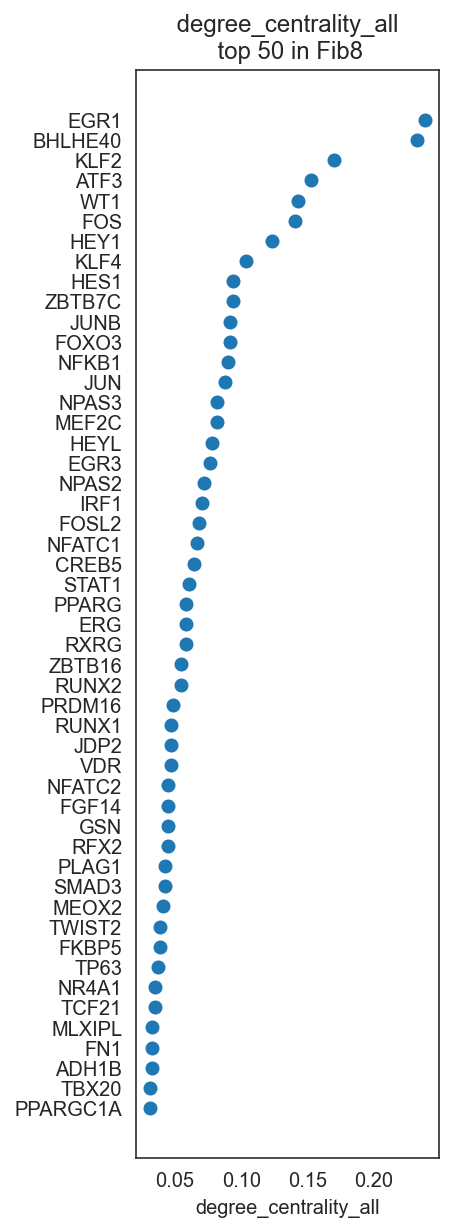

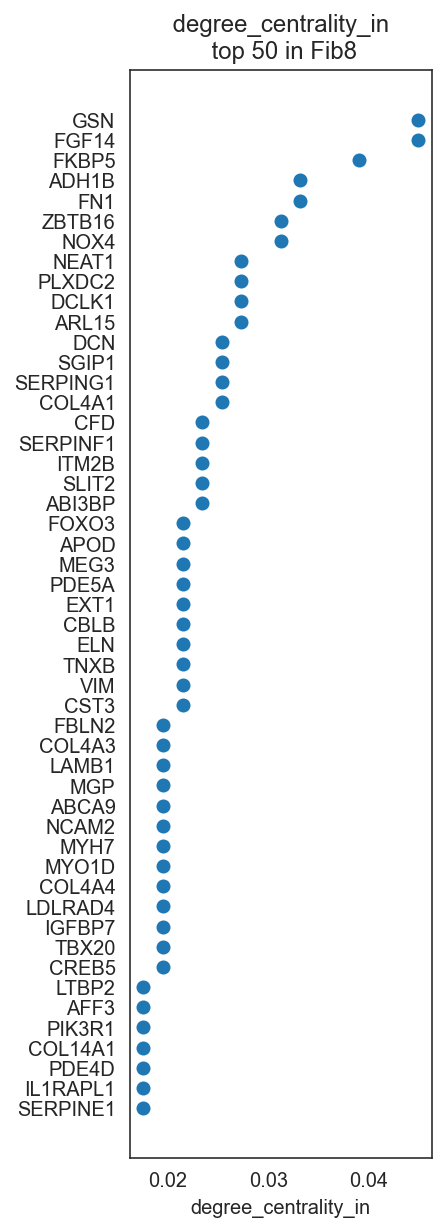

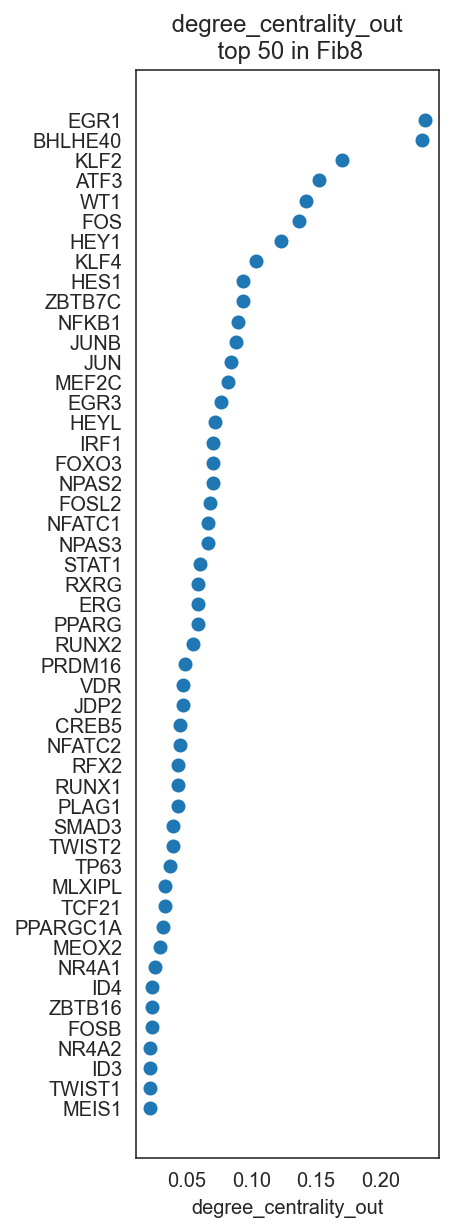

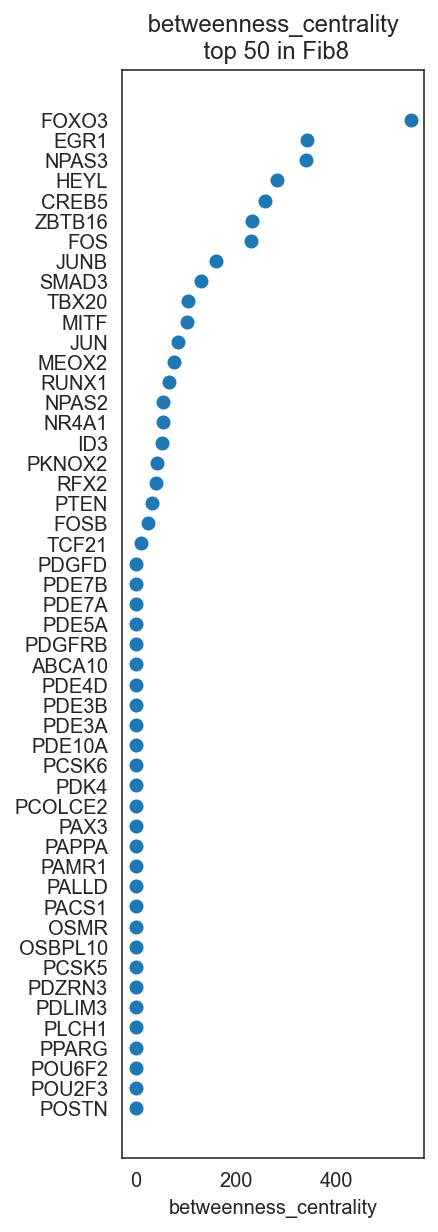

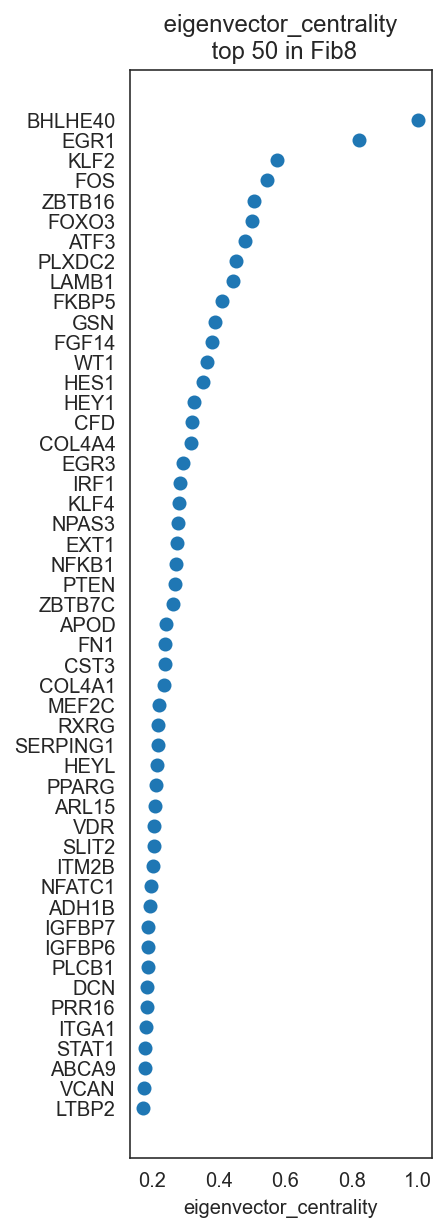

RUNX1


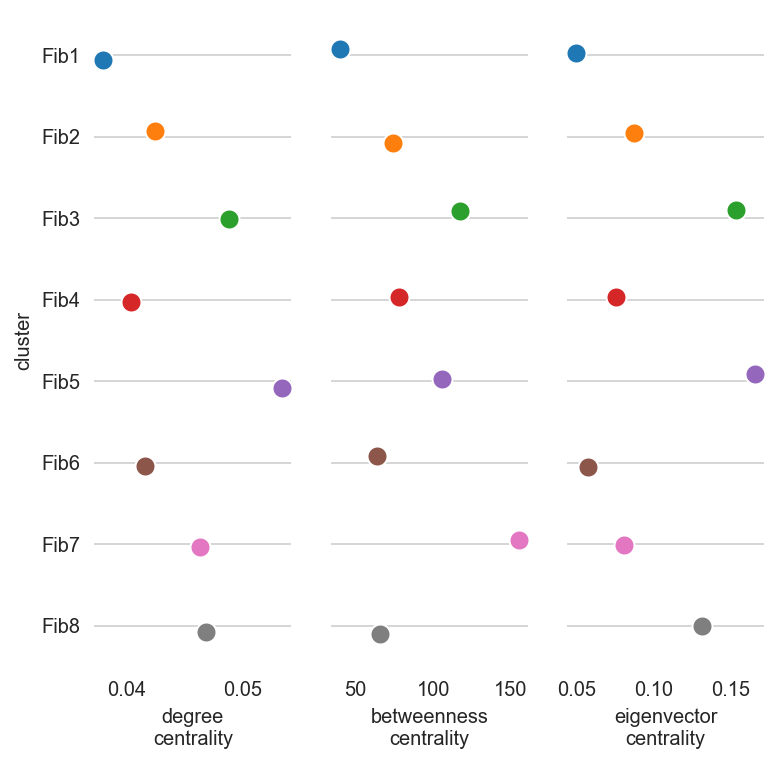

In [36]:
save_folder = "Fibroblast_GRN_per_celltype"
os.makedirs(save_folder, exist_ok=True)


links = co.load_hdf5("links_fibroblast_cell.type.celloracle.links")
links.merged_score.to_csv(f"{save_folder}/scores.csv")

plt.rcParams["figure.figsize"] = [6, 10]

for i in links.cluster:
    # Visualize top n-th genes with high scores.
    links.plot_scores_as_rank(cluster=i, n_gene=50, save=f"{save_folder}/ranked_score")
    
    
plt.rcParams["figure.figsize"] = [6, 6]
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="RUNX1", save=f"{save_folder}/network_score_per_gene/")

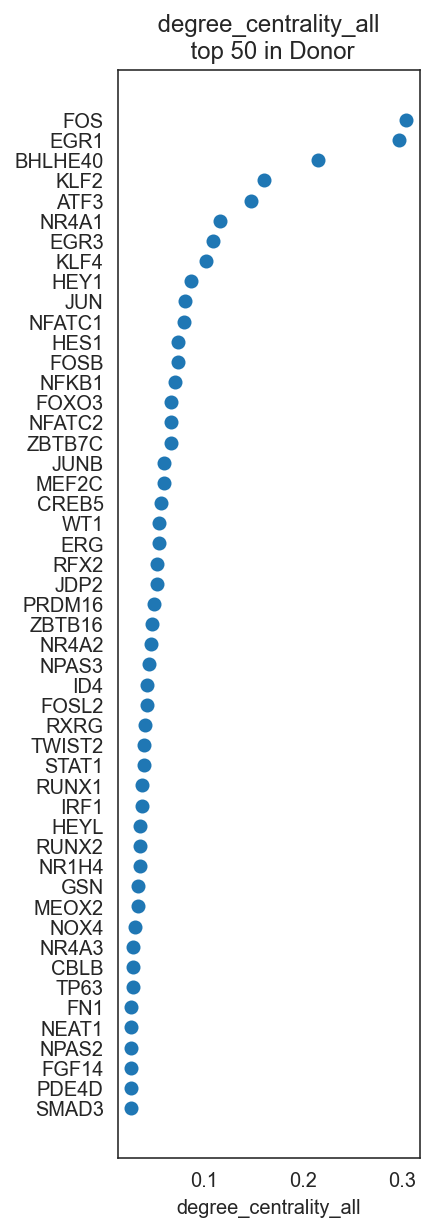

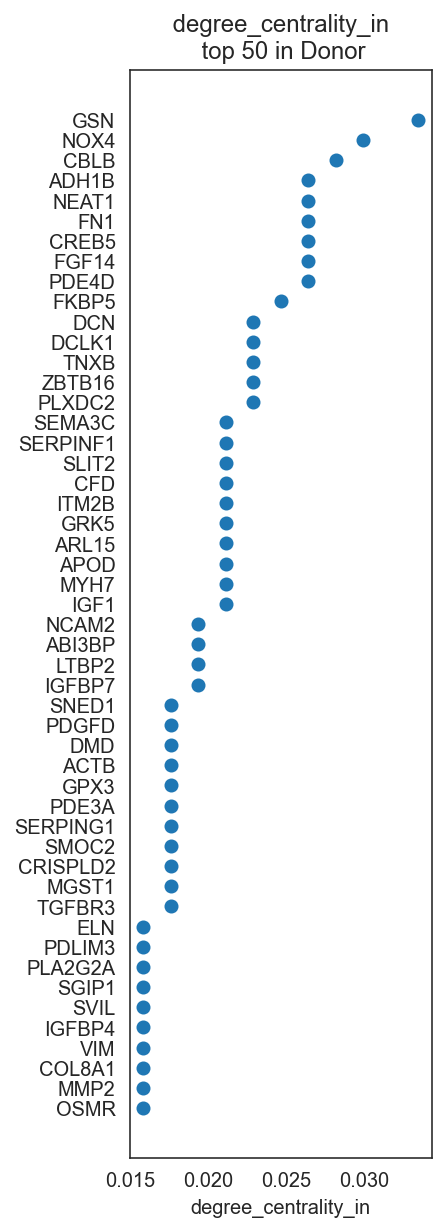

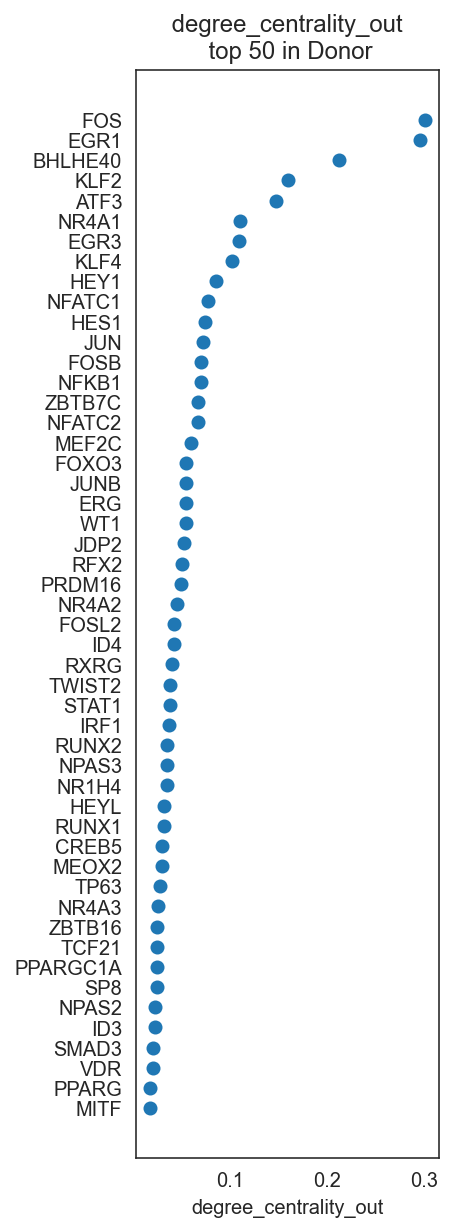

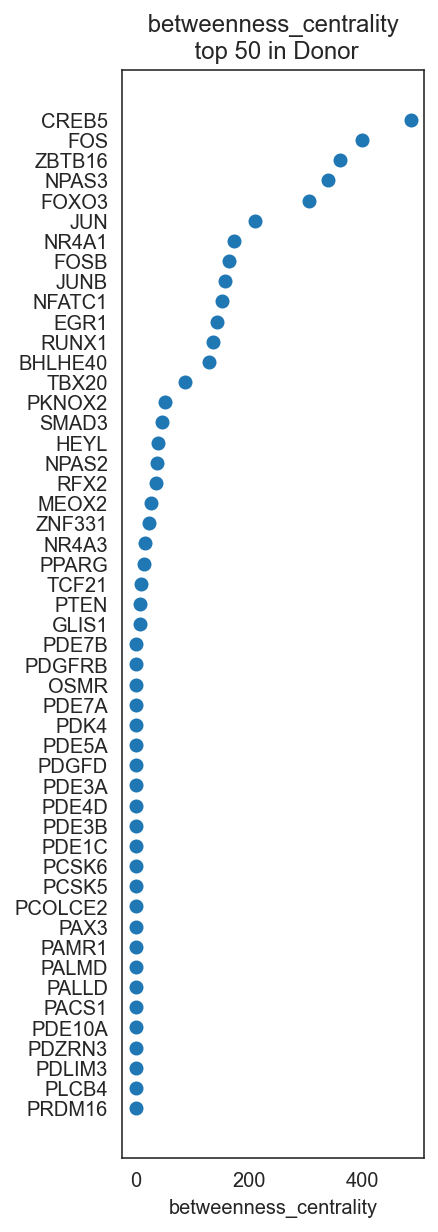

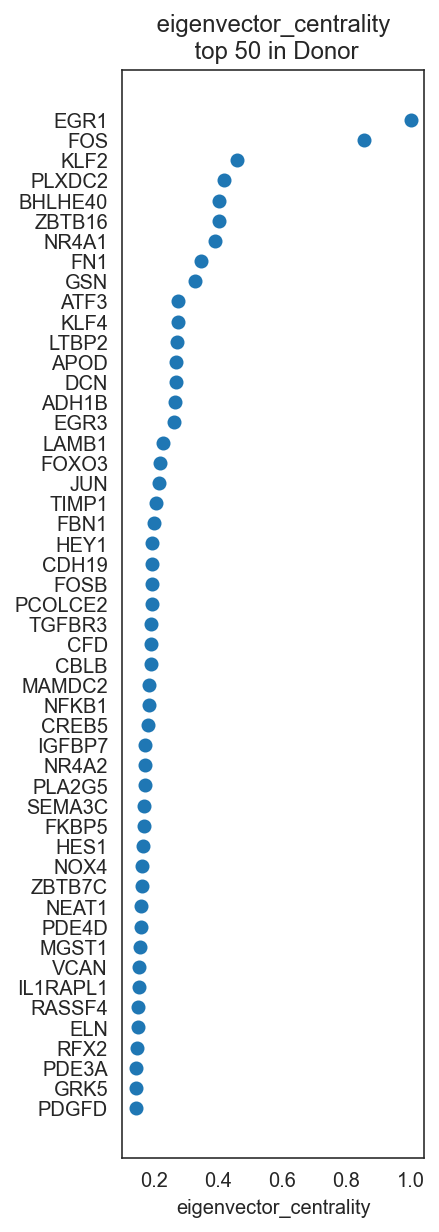

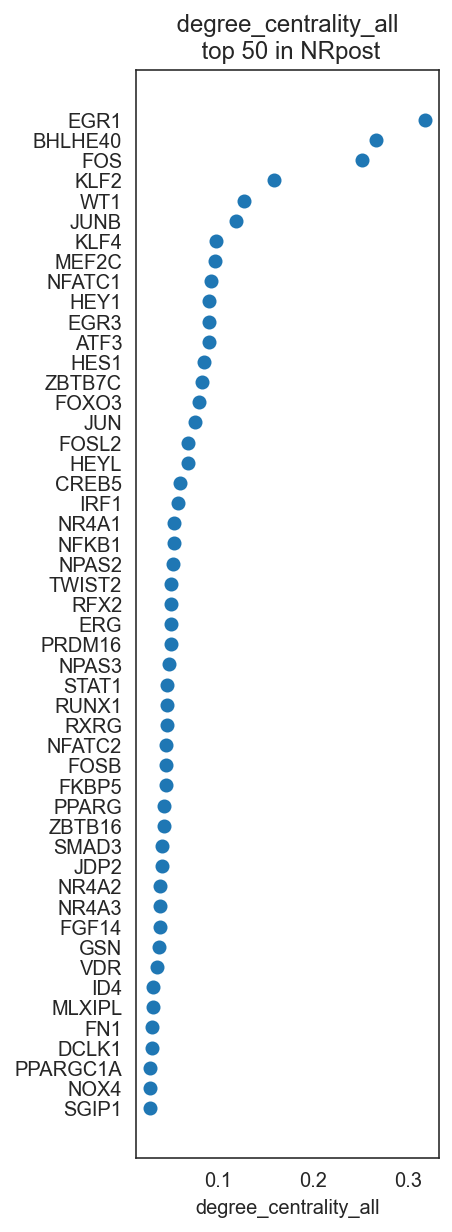

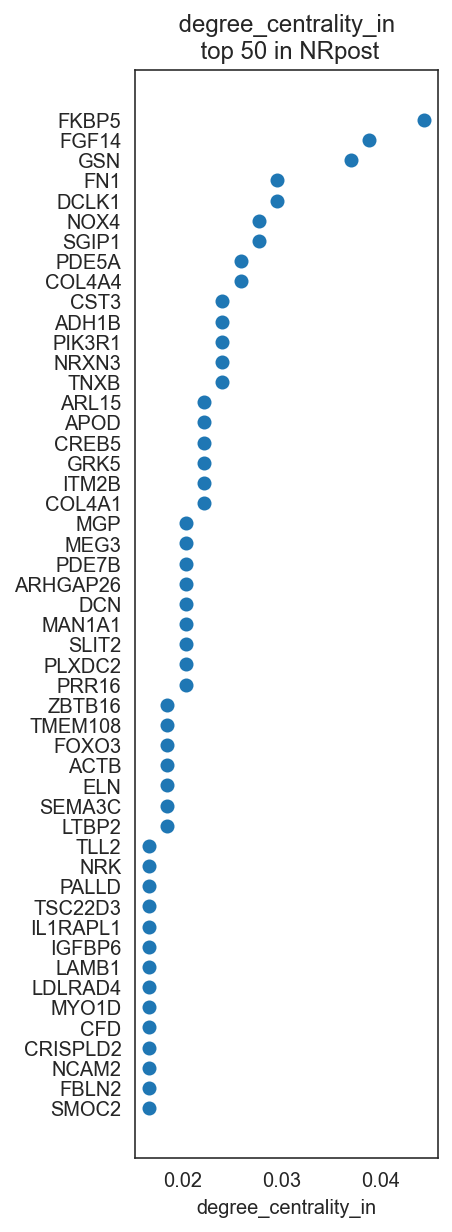

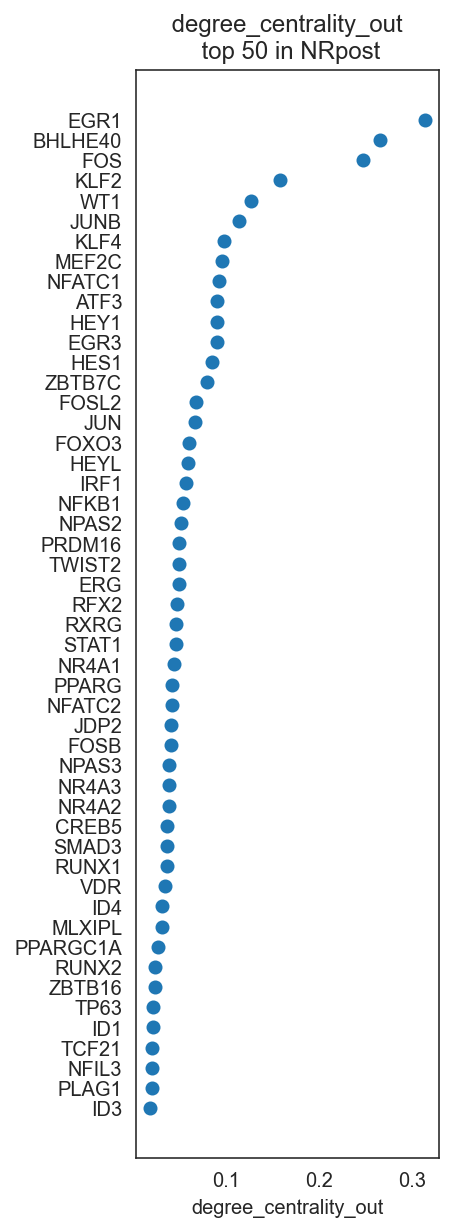

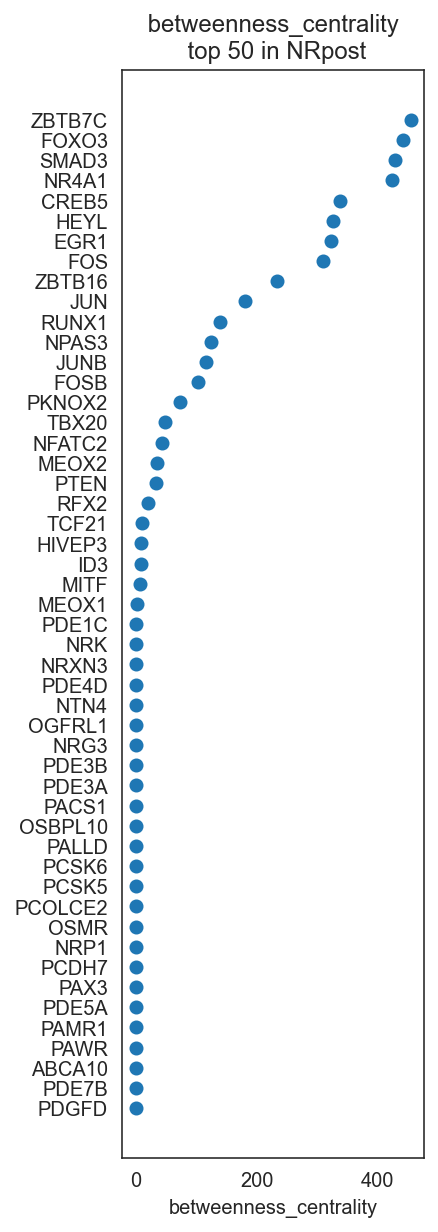

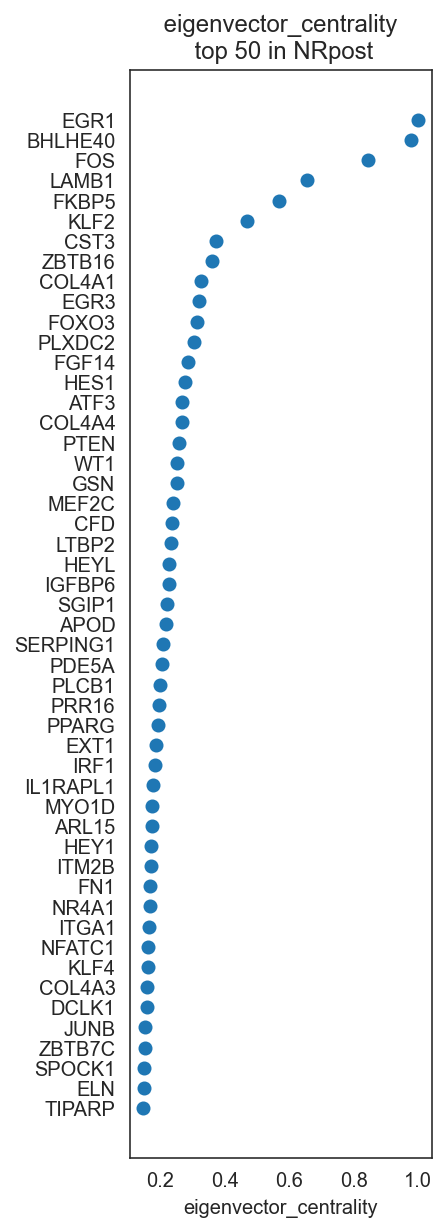

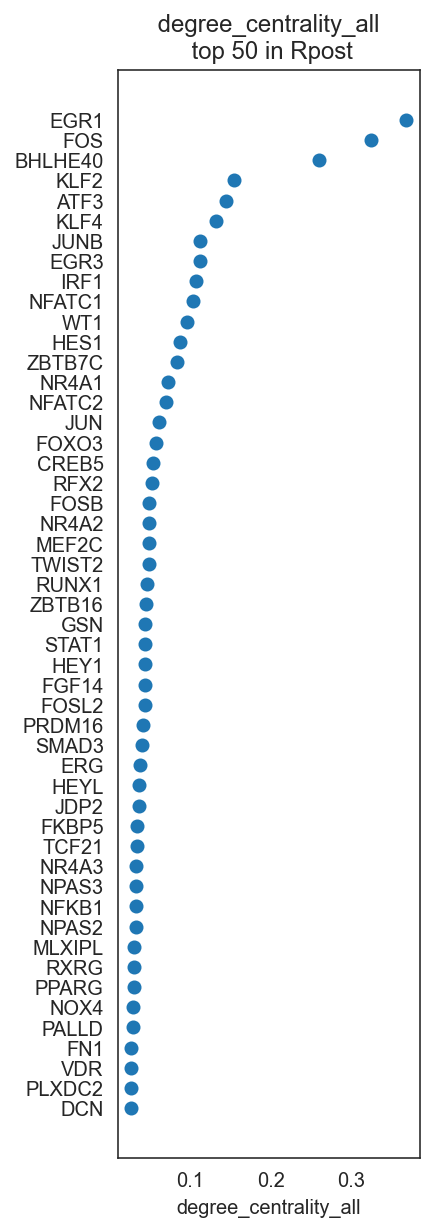

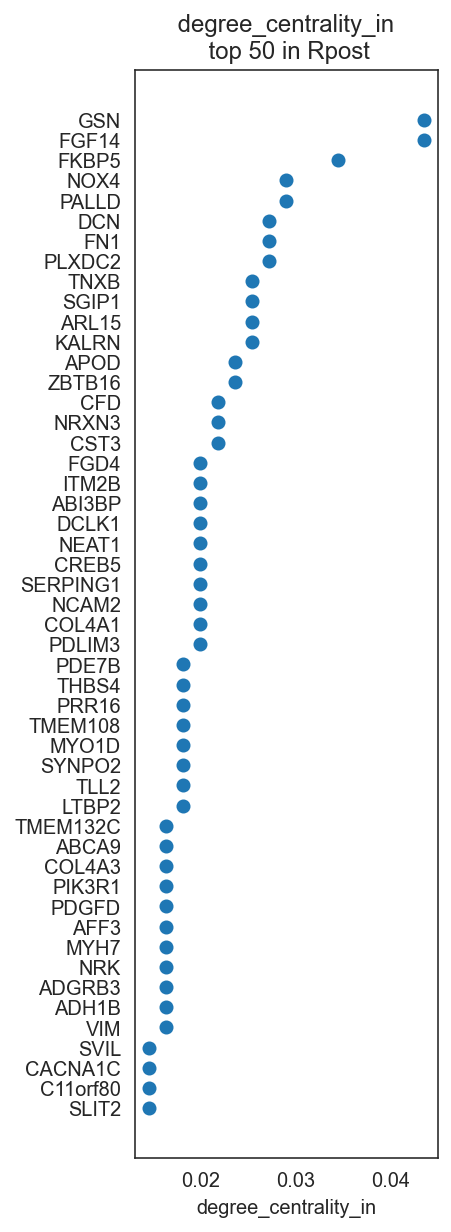

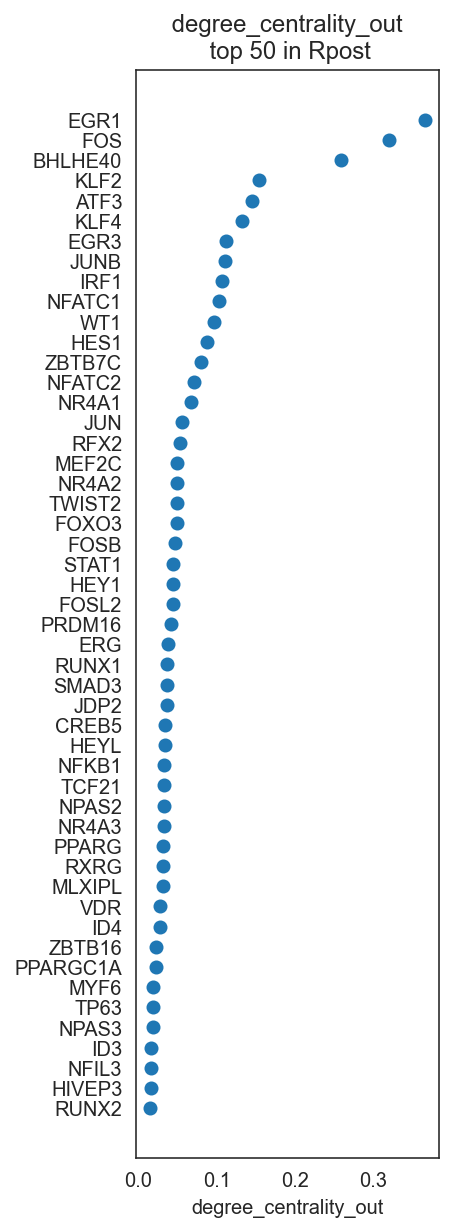

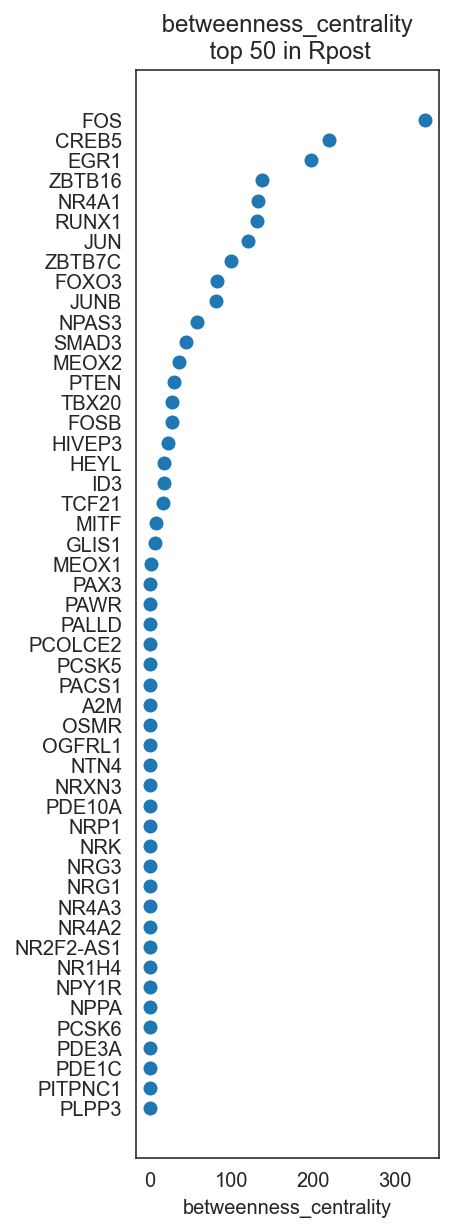

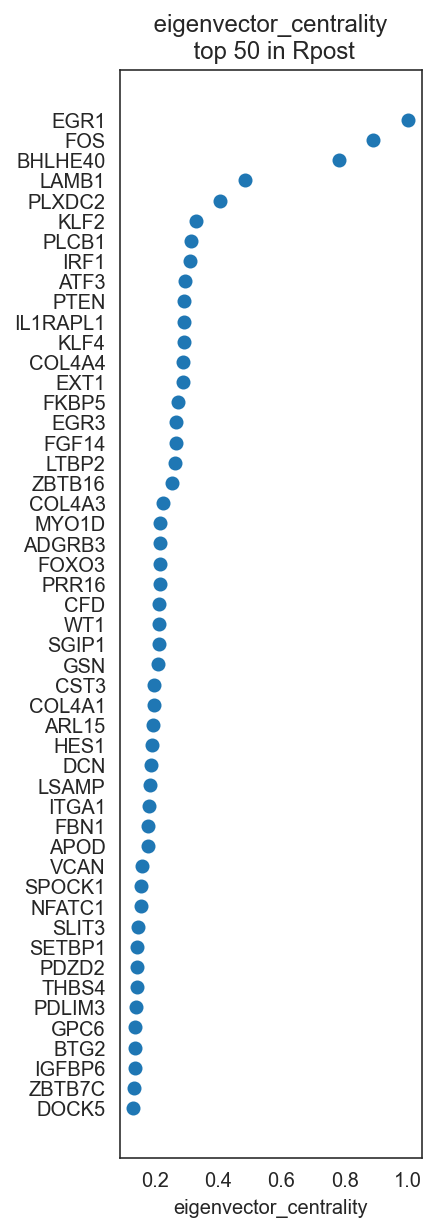

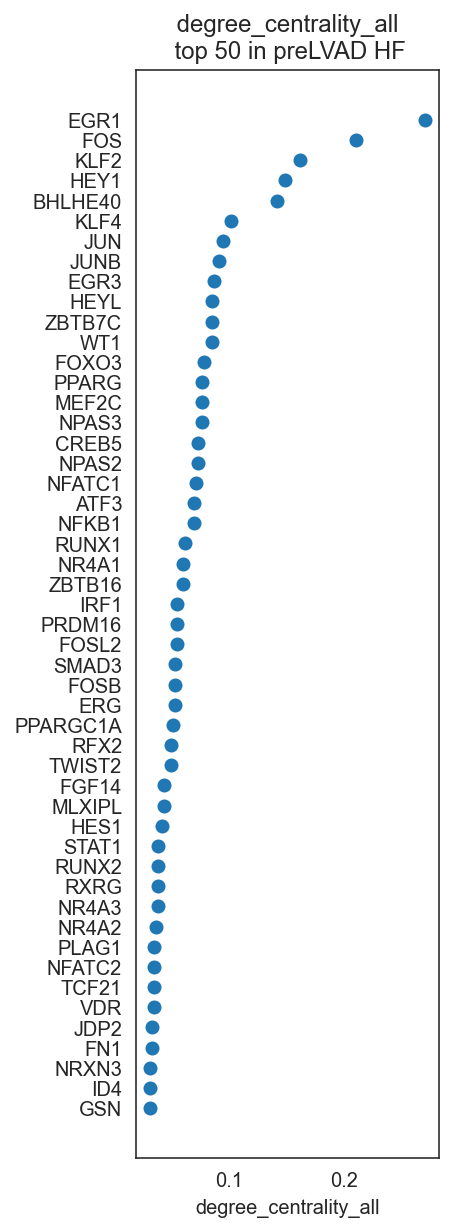

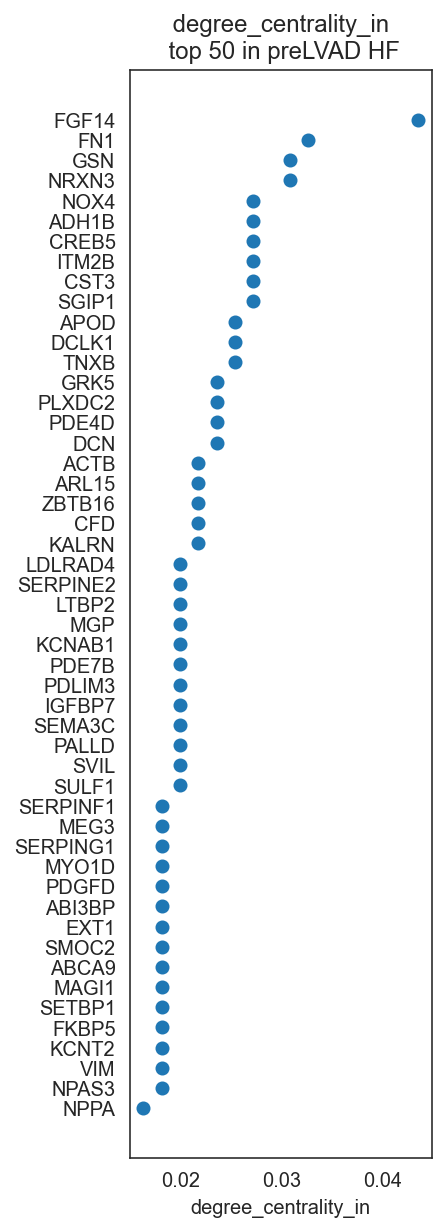

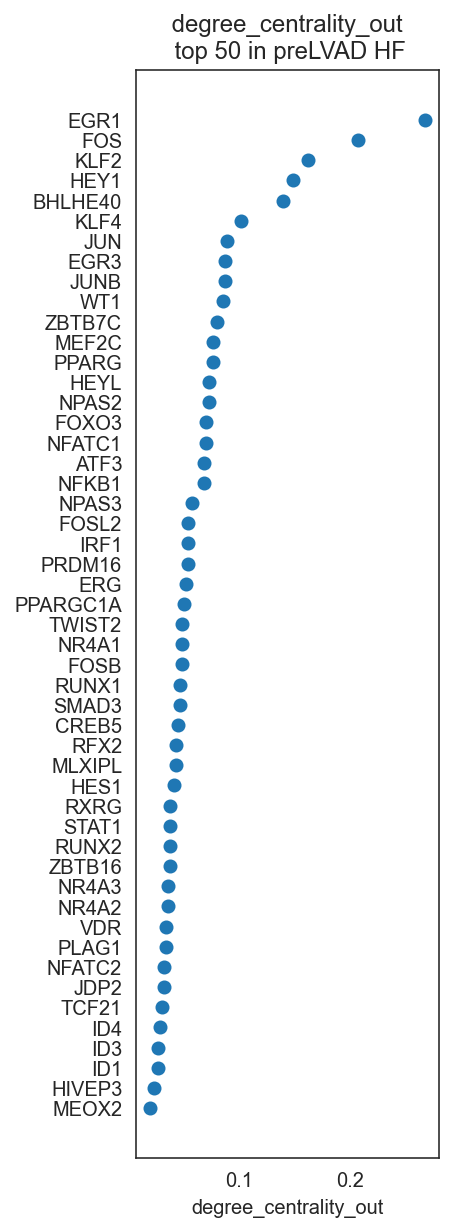

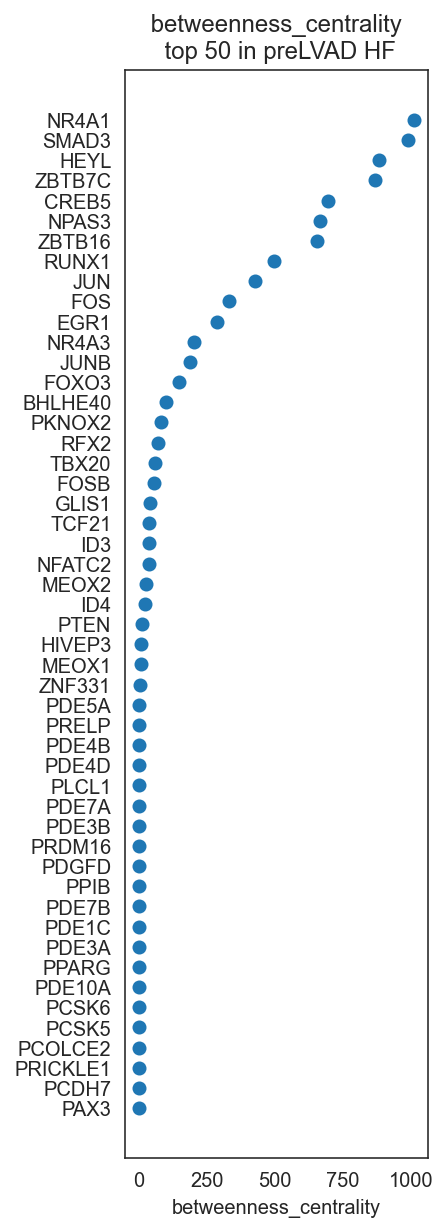

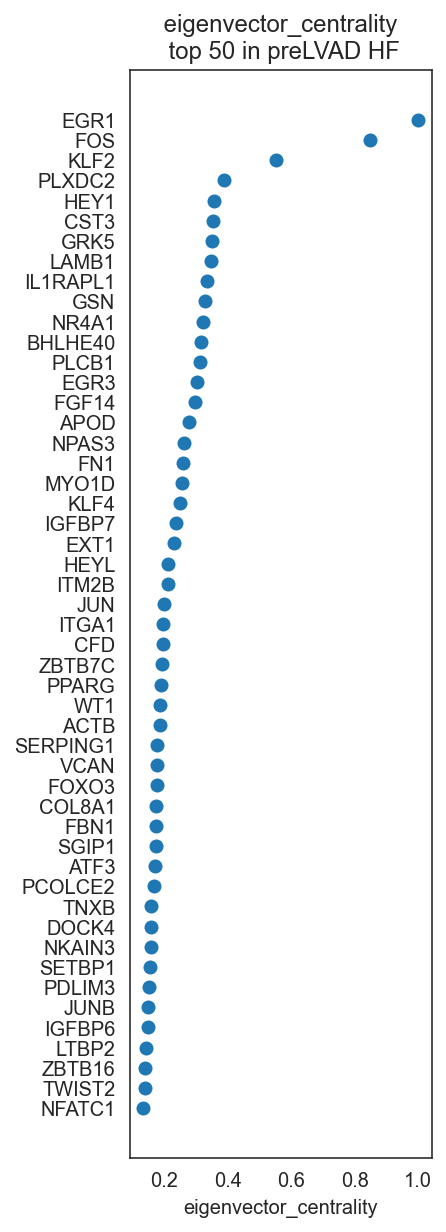

RUNX1


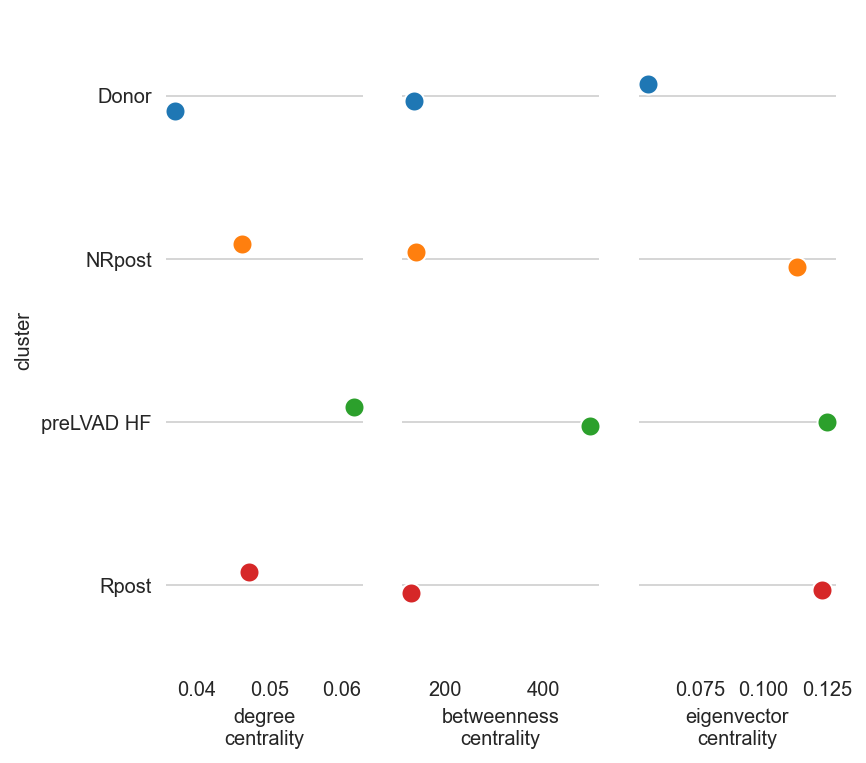

In [37]:

save_folder = "Fibroblast_GRN_per_condition"
os.makedirs(save_folder, exist_ok=True)


links = co.load_hdf5("links_fibroblast_condition.celloracle.links")
links.merged_score.to_csv(f"{save_folder}/scores.csv")

plt.rcParams["figure.figsize"] = [6, 10]

for i in links.cluster:
    # Visualize top n-th genes with high scores.
    links.plot_scores_as_rank(cluster=i, n_gene=50, save=f"{save_folder}/ranked_score")
    
    
plt.rcParams["figure.figsize"] = [6, 6]
# Visualize Gata2 network score dynamics
links.plot_score_per_cluster(goi="RUNX1", save=f"{save_folder}/network_score_per_gene/")

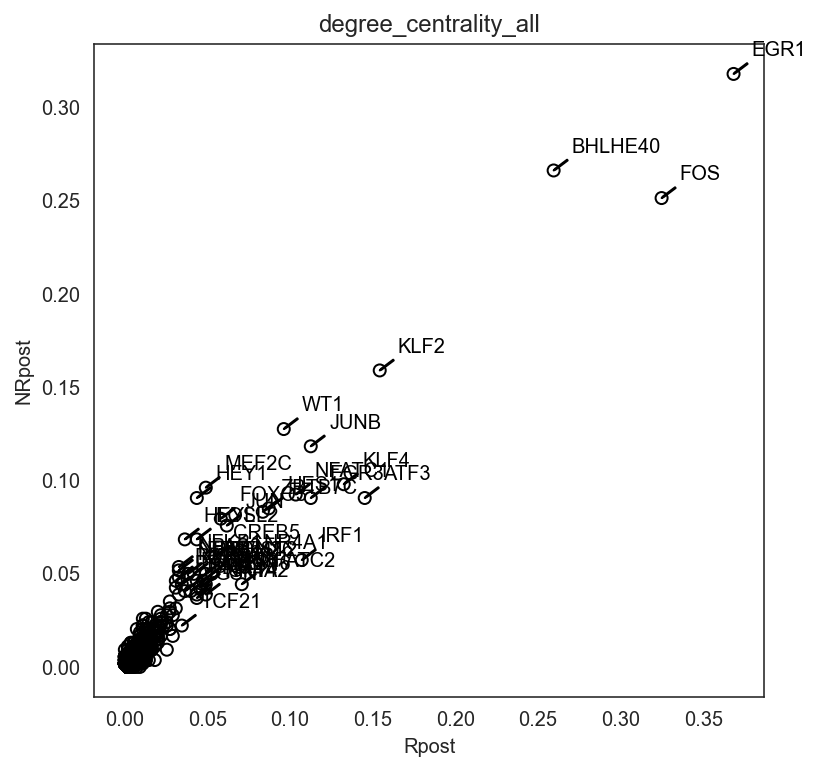

In [38]:
links.plot_score_comparison_2D("degree_centrality_all", 
                               cluster1='Rpost',
                               cluster2="NRpost",
                               percentile=94, 
                               save=f"{save_folder}/network_score_comparison/"
                               )

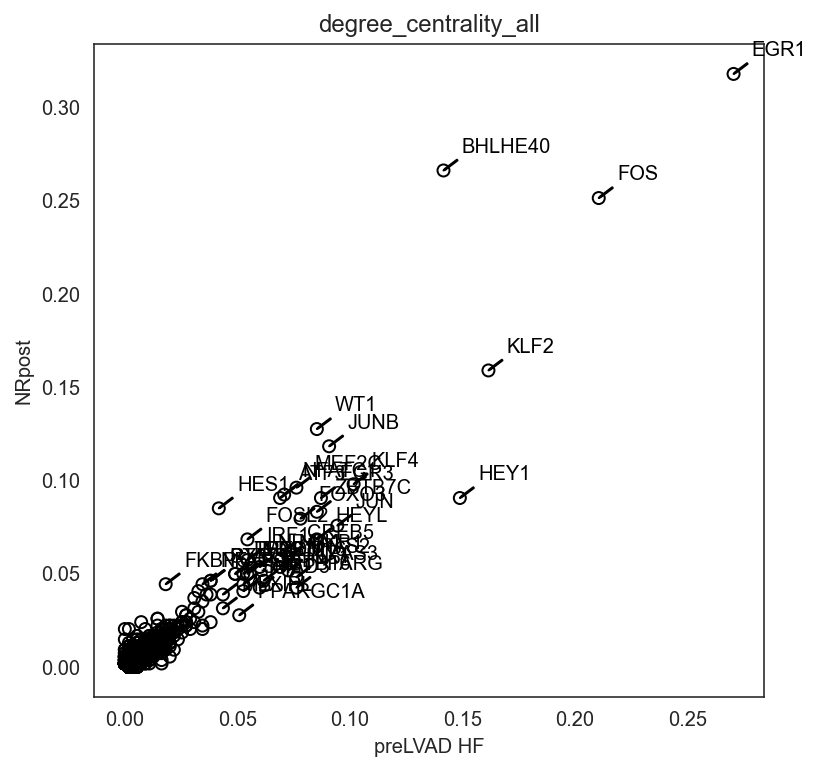

In [39]:
links.plot_score_comparison_2D("degree_centrality_all", 
                               cluster1='preLVAD HF',
                               cluster2="NRpost",
                               percentile=94, 
                               save=f"{save_folder}/network_score_comparison/"
                               )

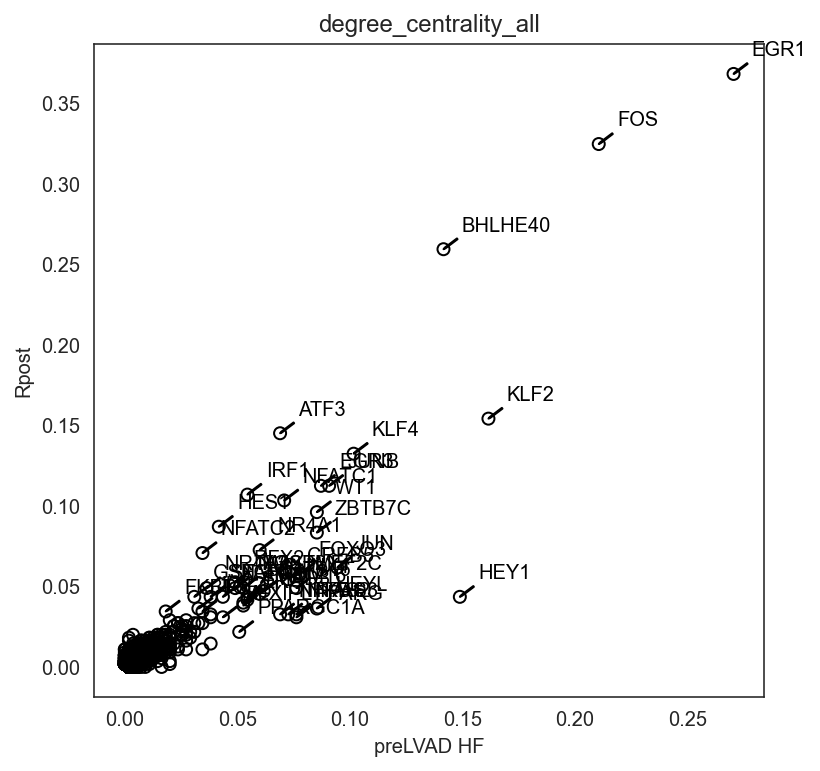

In [40]:
links.plot_score_comparison_2D("degree_centrality_all", 
                               cluster1='preLVAD HF',
                               cluster2="Rpost",
                               percentile=94, 
                               save=f"{save_folder}/network_score_comparison/"
                               )